# TO DO




In [1]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mlhep_stats

import matplotlib.pyplot as plt

import zfit
# mplhep.style.use("LHCb2")
import modplot
import numpy as np
import pandas as pd
import uproot


gpus = tf.config.experimental.list_physical_devices('GPU')
print(tf.__version__)

2024-04-09 13:03:47.837915: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 13:03:47.839516: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 13:03:47.879896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 13:03:47.881058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 13:03:48.524751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

2.13.0


2024-04-09 13:03:50.979305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 13:03:51.004586: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


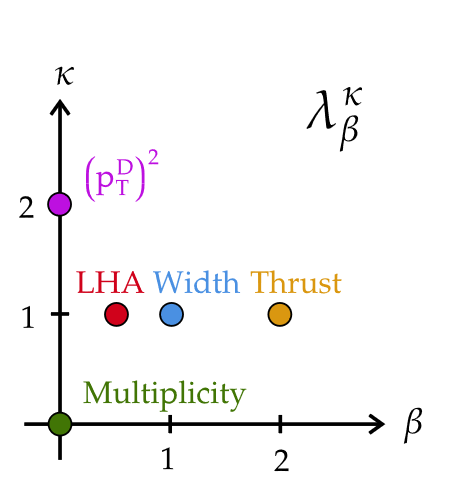

# OmniFold


In [2]:
D0masMin = 1
D0masMax = 3
D0ptMin = 1.0

D0ExpCut = f"(D0mass > {D0masMin}) & (D0mass<{D0masMax}) & (D0_pT>{D0ptMin})"
nEvents=1000000
centralityBins=[0,10]   # corresponds to 0 bin
# centralityBins=[10,40] # corresponds to 1 bin
centralityBins=[40,80] # corresponds to 2 bin
# centralityBins=[0,80] # corresponds to 2 bin
# features = ["pt","z" , "lambda_1_1", "lambda_1_1half","lambda_1_2","lambda_1_3","eta", "nconst", "dispersion","area","lambda_1_half"]
features = [ "pt", "z", "eta", "dispersion", "area", "lambda_1_1"]
            #  "lambda_1_1", "lambda_1_1half", "lambda_1_2", "lambda_1_3", "lambda_1_half" ]

isClosureTest = False
tag = "charged"
iterations = 4

# embedding_tree = uproot.open("/home/prozorov/dev/star/output_jets.root:Jets")
# exp_tree       = uproot.open("/home/prozorov/dev/star/OUTPUT_2014_20012024.root:Jets")

exp_tree       = uproot.open("/home/prozorov/dev/star/2014_text_trackbased_notall.root:Jets")
embedding_tree = uproot.open("/home/prozorov/dev/star/output_jets_charged.root:Jets")

# droput rate
dropout_rate = 0.1



saveFolder = f"realData/centrality{centralityBins[0]}_{centralityBins[1]}"
if isClosureTest:
    saveFolder =f'closureTest/centrality{centralityBins[0]}_{centralityBins[1]}'

saveFolder = saveFolder + f'/{tag}'

import os
os.makedirs(saveFolder, exist_ok=True)


## ZFit 
Returns weights for centrality


In [3]:
from hepstats.splot import compute_sweights

obs = zfit.Space('D0mass', limits=(D0masMin, D0masMax))
mu = zfit.Parameter("mu", 1.865, 1.8, 1.92, step_size=0.0001)
sigma = zfit.Parameter("sigma", 0.02, 0.001, 0.3, step_size=0.0001)
lambd = zfit.Parameter("lambda", -3.0)
sig_yield = zfit.Parameter('sig_yield', 5300, 0, 100000,
                                step_size=10)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 25000, 0, 3e5, step_size=10)

def getSWeights(exp):
# model building, pdf creation
    signal_pdf  = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
    comb_bkg_pdf  = zfit.pdf.Exponential(lambd, obs=obs)

    data= zfit.Data.from_pandas(exp)

# Create the extended models
    extended_sig = signal_pdf.create_extended(sig_yield)
    extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
    model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

# plot the data
    data_mass = data["D0mass"].numpy()

# Builds the loss.
    data_sw = zfit.Data.from_numpy(obs=obs, array=data_mass)
    nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
    sigma.floating = False

# Minimizes the loss.
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    result_sw = minimizer.minimize(nll_sw)
   
    weights = compute_sweights(model, data_sw)
    return weights[sig_yield]


def getEfficiencyD0Yield(pT, centrality):
    # 2014 efficiency
    #                   0-10% ,  10-20% , 20-40% , 40-60% ,  60-80%

    efficiencies=[[0.000285808, 0.000295828, 0.000279927, 0.000596018, 0.000790277],  # pT = 0-0.5
                  [0.000421541, 0.00047328,  0.000699687, 0.000715744, 0.000884337],  
                  [0.00092226,  0.00109118,  0.00168991,  0.00183595,  0.00180872],
                  [0.0021721,   0.00288962,  0.00386534,  0.00415397,  0.0037352],
                  [0.00438539,  0.00584226,  0.00684054,  0.00824008,  0.00896017],
                  [0.00763724,  0.0093116,   0.011732,    0.0143702,   0.0154568],
                  [0.0126991,   0.0164649,   0.0189316,   0.022335,    0.0226727],
                  [0.0162577,   0.022248,    0.0255858,   0.0295719,   0.0300738],
                  [0.0198151,   0.0266207,   0.0299858,   0.0346729,   0.0363673],
                  [0.0232576,   0.0294244,   0.034567,    0.0390242,   0.0422618],
                  [0.0302067,   0.0399938,   0.042766,    0.0465076,   0.0471732],
                  [0.0320288,   0.0417054,   0.0464353,   0.0503547,   0.0484834],
                  [0.0346935,   0.0450093,   0.0493515,   0.0534783,   0.0536006],
                  [0.0369348,   0.0471141,   0.0520191,   0.0584171,   0.0565219],
                  [0.0375094,   0.0486814,   0.0546515,   0.0588733,   0.0568737],
                  [0.0379939,   0.0486559,   0.0564554,   0.0613643,   0.0580419],
                  [0.0392913,   0.0529509,   0.0577245,   0.0630573,   0.059229],
                  [0.0398821,   0.0509655,   0.0589518,   0.0630945,   0.0604374],
                  [0.0408044,   0.0534084,   0.0606451,   0.0655055,   0.061268],
                  [0.0410468,   0.0552335,   0.0605044,   0.0678948,   0.0616327]]
    

    ptBins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,  4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 15]

    centBins = [0, 10, 20, 40, 60, 80]
    pT_range = 0
    centr_range = 0
    for i in range(len(ptBins)):
        if pT >= ptBins[i] and pT < ptBins[i+1]:
            pT_range = i
            break
    for i in range(len(centBins)):
        if  centrality >= centBins[i] and centrality < centBins[i+1]:
            centr_range = i
            break
    return efficiencies[pT_range][centr_range]

#     //https://inspirehep.net/literature/2051708
#     // https://journals.aps.org/prc/abstract/10.1103/PhysRevC.99.034908

# //D0 2014 efficiency                        0-10% ,     10-20% , 20-40% ,  40-60%  60-80%
#     const double efficiencies[11][5]={     {0.000622, 0.000740, 0.00088, 0.00108, 0.00140},         //pT = 0-0.5
#                                            {0.000717,0.000717, 0.00110, 0.00143, 0.00160},          //pT = 0.5-1.0
#                                            {0.001025, 0.001300, 0.00195, 0.00304, 0.00289},         //pT = 1.0-1.5
#                                            {0.002248, 0.003014, 0.00411, 0.00610, 0.00528},         //pT = 1.5-2.0
#                                            {0.003794,0.006104, 0.00738, 0.01072, 0.00997},          //pT = 2.0-2.5
#                                            {0.006107, 0.009671, 0.01006, 0.01606, 0.01447},         //pT = 2.5-3.0
#                                            {0.011249, 0.016457, 0.02087, 0.02565, 0.02482},         //pT = 3.0-4.0
#                                            {0.015830, 0.023905, 0.02984, 0.03553, 0.03663},         //pT = 4.0-5.0
#                                            {0.026520, 0.034723,   0.04134, 0.04656,0.04032},          //pT = 5.0-6.0
#                                            {0.029904, 0.040095,0.04888, 0.05334,0.05080},           //pT = 6.0-8.0
#                                            {0.032680,0.045229,    0.05514,0.06017,0.05685} };         //pT = 8.0-10.0

#     //https://drupal.star.bnl.gov/STAR/system/files/2018_1109_D0spectra_Note.pdf
#     //D0 2016 efficiency                        0-10%       10-20%  20-40%   40-60%      60-80%
#     const double efficiencies2016[11][5] = {  {0.000669, 0.000741, 0.000845, 0.000981, 0.001094},    //pT = 0-0.5
#                                               {0.000741, 0.000707, 0.001018, 0.001216, 0.001305},    //pT = 0.5-1.0
#                                               {0.001037, 0.001285, 0.001957, 0.002952, 0.002222},    //pT = 1.0-1.5
#                                               {0.002358, 0.002978, 0.004169, 0.005517, 0.004192},    //pT = 1.5-2.0
#                                               {0.004128, 0.006111, 0.007096, 0.009658, 0.008442},    //pT = 2.0-2.5
#                                               {0.006282, 0.009654, 0.010210, 0.014426, 0.012034},    //pT = 2.5-3.0
#                                               {0.012071, 0.016277, 0.020178, 0.024096, 0.020480},    //pT = 3.0-4.0
#                                               {0.018021, 0.023850, 0.028217, 0.033696, 0.029730},    //pT = 4.0-5.0
#                                               {0.026160, 0.034300, 0.042521, 0.047122, 0.033852},    //pT = 5.0-6.0
#                                               {0.029773, 0.039774, 0.047944, 0.051664, 0.038528},    //pT = 6.0-8.0
#                                               {0.032934, 0.044408, 0.054539, 0.058225, 0.043018} }; //pT = 8.0-10.0
# }

In [4]:
# with uproot.open("/home/prozorov/dev/star/unfold/JetFinderEfficiency.root") as file:
#     hist=file["JetFinderEfficiency"] #2d histogram
#     eff=hist.to_numpy()
#     values = eff[0]
#     ptBinsEdges = eff[1]
ptBinsEdges =( 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 18, 30)
# centrality : 0-10%,     10-40%,    40-80%
values =  [ [0.8040493,  0.83887934, 0.91436481],
            [0.83531431, 0.87066498, 0.93592894],
            [0.86378964, 0.89502397, 0.94950428],
            [0.8858829,  0.91200534, 0.95879075],
            [0.90171456, 0.92392761, 0.96557282],
            [0.91389318, 0.93324831, 0.97033296],
            [0.92173535, 0.94047693, 0.97348525],
            [0.92743685, 0.94662845, 0.97777634],
            [0.93525452, 0.94907014, 0.97975429],
            [0.94756974, 0.95762499, 0.98211105],
            [0.95040946, 0.96266307, 0.98382422],
            [0.96602388, 0.96608892, 0.98780008],
            [0.96862745, 0.96307934, 0.99102773]
]
def getSimJetFinderEfficiency(pt, centralityBin): #centralityBin = 0 (0-10%) , 1(10-40%) or 2(40-80%)
    ptBin = np.digitize(pt, ptBinsEdges)-1
    if (ptBin<0):
        ptBin=0
    elif (ptBin>=len(values)):
        ptBin=len(values)-1
    return values[ptBin][centralityBin]

## Setup the Datasets

In [5]:

centralityCuts = ["(Centrality >= {}) & (Centrality < {})".format(centralityBins[i], centralityBins[i+1]) for i in range(len(centralityBins)-1)]

# make centrality dependent analysis
print("Processing centrality bin: ", centralityCuts[0])

# RunId
# centrality
# centr_weight
# NJet
# pseudorapidity
# jet_phi
# grefmult
# bg_dens
# jet_area
# jet_rap
# jet_pt
# jet_pt_corr
# D0mass
# D0_r
# D0_pT
# lambda_1_0half
# lambda_1_1
# lambda_1_1half
# lambda_1_2
# lambda_1_3
# lambda_2_0
# z
# NConst
# NpTfraction
# D0_rap


exp = exp_tree.arrays(["D0_pT","D0mass", "D0_r", "centrality", "centr_weight", "jet_pt_corr", "pseudorapidity",
                       "z", "lambda_1_1","lambda_1_1half","lambda_1_2","lambda_1_3", "NConst", "lambda_1_0half", "lambda_2_0", "bg_dens", "jet_area"], 
                       cut=D0ExpCut + "& (abs(pseudorapidity) <= 0.6)", library='pd')
#apply centrality cut
mapCentrality = {0:70, 1:60, 2:50, 3:40, 4:30, 5:20, 6:10, 7:5, 8:0}
exp["centrality"]  = exp["centrality"].apply(lambda x: mapCentrality[x])
jetFilter =(exp["centrality"]>=centralityBins[0]) & (exp["centrality"]<centralityBins[1])
exp = exp.loc[jetFilter]
expcopy = exp.copy()
exp["SWeight"] = getSWeights(expcopy)

print(exp.head())
exp["Eff"] = exp.apply(lambda row: getEfficiencyD0Yield(row["D0_pT"], row["centrality"]), axis=1)
print(exp.head())
exp["Weight"] = exp["SWeight"]*exp["Eff"]*exp["centr_weight"]
print(exp.head())

exp_max_pt = exp["jet_pt_corr"].max()
exp_min_pt = exp["jet_pt_corr"].min()


exp.drop(columns=["SWeight", "Eff", "centr_weight", "D0_pT","D0mass", "centrality"], inplace=True)
exp.rename(columns={"jet_pt_corr": "pt","pseudorapidity":"eta", "NConst": "nconst", "bg_dens": "rho", "jet_area": "area", "lambda_1_0half" : "lambda_1_half" 
                     }, inplace=True)

exp ['dispersion'] = np.sqrt(exp['lambda_2_0'])


columns = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3", "McJetEta", "McJetDispersion", "McJetArea", "McJetNConst", "McJetLambda_1_half",
            "RecoJetPt","RecoJetD0Z", "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","RecoJetEta", "RecoJetDispersion", "RecoJetArea", "RecoJetNConst", "RecoJetLambda_1_half", "RecoJetRhoVal",
            "Centrality", "Weight" ]


sim_mc_reco= embedding_tree.arrays(columns, cut=centralityCuts[0] + "& (RecoJetNConst!=0)" + "& (RecoJetPt<=45)" , library="pd", entry_stop=nEvents)

# clean sim_mc_reco for min and max pt values of exp
sim_mc_reco = sim_mc_reco[(sim_mc_reco["RecoJetPt"]>exp_min_pt) & (sim_mc_reco["RecoJetPt"]<exp_max_pt)]

centralityBinMap = {0:0, 10:1, 40:2}
sim_mc_reco["Weight"] = sim_mc_reco["McJetPt"].apply( lambda pt: getSimJetFinderEfficiency(pt, centralityBinMap[centralityBins[0]]))

print("Data events: ", len(exp))
print("MC events: ", len(sim_mc_reco))

print(exp.head())


# upsample exp data to balance sim_mc_reco
exp = exp.sample(n=int(len(sim_mc_reco)/3), replace=True, random_state=42)



Processing centrality bin:  (Centrality >= 40) & (Centrality < 80)
        D0_pT    D0mass      D0_r  centrality  centr_weight  jet_pt_corr  \
12   1.689789  1.854361  0.239341          40      1.013643     7.699662   
13   1.689789  1.787630  0.239341          40      1.013643     7.782462   
48   3.732025  1.931117  0.092704          40      1.055716     5.694791   
147  2.591268  1.769798  0.222972          60      1.441475     4.816867   
148  2.591268  1.853779  0.222972          60      1.441475     5.071701   

     pseudorapidity         z  lambda_1_1  lambda_1_1half  lambda_1_2  \
12         0.159083  0.220841    1.036673        0.857101    0.719492   
13         0.159083  0.219446    1.025643        0.847982    0.711837   
48        -0.735869  0.662781    0.694822        0.500666    0.380840   
147       -0.331215  0.540388    0.618621        0.424325    0.293197   
148       -0.331215  0.512513    0.587538        0.403004    0.278465   

     lambda_1_3  NConst  lambda_1_0ha

In [6]:
exp

,D0_r,pt,eta,z,lambda_1_1,lambda_1_1half,lambda_1_2,lambda_1_3,nconst,lambda_1_half,lambda_2_0,rho,area,Weight,dispersion
32579,0.069698,2.775899,-0.309869,1.271599,0.478644,0.301683,0.213745,0.136087,4.0,0.859316,1.657652,4.162888,0.468746,0.025906,1.287498
215274,0.033732,2.424074,-0.459315,0.866373,0.564253,0.373490,0.285189,0.214995,8.0,1.019258,1.122260,6.355518,0.458772,0.013398,1.059368
208977,0.091973,5.485427,0.597810,0.597445,0.631986,0.437347,0.319355,0.193337,8.0,0.970504,0.538354,6.050029,0.528585,0.031757,0.733726
207933,0.248723,7.930502,-0.418619,0.354070,0.935711,0.751390,0.612856,0.421436,15.0,1.191169,0.252324,7.999841,0.548532,-0.007851,0.502319
152134,0.035382,0.542320,-0.410285,4.829446,0.766400,0.465076,0.360686,0.289445,2.0,1.726572,20.223452,4.066512,0.518612,-0.000409,4.497049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190058,0.405187,2.066986,-1.005257,0.562810,1.358052,1.267601,1.205280,1.141346,4.0,1.485030,0.744002,3.467123,0.388959,0.002650,0.862556
216598,0.084451,-0.457592,0.405324,-2.073499,-2.521389,-1.577969,-1.023776,-0.472239,6.0,-4.187202,11.742814,9.403558,0.398932,-0.001481,3.426779
181900,0.017287,5.367673,-0.689485,1.211464,0.107092,0.054646,0.037159,0.022253,2.0,0.319619,1.460469,3.472585,0.448799,0.070119,1.208499
39357,0.047789,3.047104,0.543302,1.518706,0.648609,0.435112,0.326555,0.222151,7.0,1.128494,2.368202,7.538348,0.528585,0.044277,1.538896


In [7]:
sim_mc_reco

,McJetPt,McJetD0Z,McJetLambda_1_1,McJetLambda_1_1half,McJetLambda_1_2,McJetLambda_1_3,McJetEta,McJetDispersion,McJetArea,McJetNConst,...,RecoJetLambda_1_2,RecoJetLambda_1_3,RecoJetEta,RecoJetDispersion,RecoJetArea,RecoJetNConst,RecoJetLambda_1_half,RecoJetRhoVal,Centrality,Weight
1,2.806840,0.871297,1.182813e-01,3.474475e-02,1.219228e-02,0.001950,-0.270109,0.880917,0.483059,101,...,0.061630,0.012365,-0.189768,0.569351,0.474392,103,0.923428,0.358254,65.0,0.935929
3,3.340030,0.759740,2.461089e-01,8.607191e-02,3.231918e-02,0.005337,0.490910,0.798987,0.468613,98,...,0.171724,0.047920,0.357845,0.771632,0.695138,149,1.578112,3.220963,55.0,0.949504
5,1.251951,1.000000,1.694066e-18,1.394522e-27,1.147944e-36,0.000000,-0.245307,1.000000,0.489087,101,...,0.446771,0.124578,-0.173096,1.055133,0.497637,111,3.354407,9.374784,40.0,0.914365
6,2.082619,1.000000,1.630538e-19,4.164152e-29,1.063462e-38,0.000000,-0.012729,1.000000,0.478808,99,...,0.244758,0.065739,0.117869,0.710967,0.530824,120,2.240266,9.374784,40.0,0.935929
7,3.277599,0.732608,2.376445e-01,9.043228e-02,4.072011e-02,0.011752,-0.149568,0.750062,0.507946,108,...,0.009817,0.001092,-0.131888,0.815026,0.498364,105,0.520361,0.000000,70.0,0.949504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999974,4.107427,0.841647,2.211461e-01,8.625764e-02,3.930008e-02,0.010362,0.070238,0.850213,0.488563,103,...,0.098030,0.024045,0.158838,0.599033,0.492992,106,1.059698,0.232181,65.0,0.958791
999976,1.100861,1.000000,8.077306e-17,4.591238e-25,2.609715e-33,0.000000,0.539073,1.000000,0.488724,101,...,0.282891,0.070800,0.587207,1.214672,0.395990,87,2.830345,6.021163,40.0,0.914365
999988,2.100969,0.764380,1.813114e-01,5.538743e-02,1.832353e-02,0.002373,0.425969,0.801150,0.493629,103,...,0.116653,0.026503,0.462225,1.049830,0.478310,101,1.536129,2.200192,55.0,0.935929
999989,1.262173,1.000000,1.511107e-17,3.715119e-26,9.133775e-35,0.000000,-0.284080,1.000000,0.353083,73,...,0.137758,0.023640,-0.274911,3.687273,0.478065,100,3.310598,2.603232,55.0,0.914365


In [8]:
# apply feature scaling on pt. pt = log pt

# # and add lower bound to avoid negative values for RecoJetPt
# min_pt = min(sim_mc_reco["RecoJetPt"].min(), exp["pt"].min())
# sim_mc_reco["RecoJetPt"] = np.log(sim_mc_reco["RecoJetPt"]-min_pt+1)
# # now exp
# exp["pt"] = np.log(exp["pt"]-min_pt+1)


genMcFeatures = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3","McJetEta", "McJetDispersion", "McJetArea", "McJetNConst", "McJetLambda_1_half"]
recoMcFeatures = ["RecoJetPt","RecoJetD0Z", "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","RecoJetEta", "RecoJetDispersion", "RecoJetArea", "RecoJetNConst", "RecoJetLambda_1_half"]


genMcJets = sim_mc_reco[genMcFeatures].copy()
genMcJets.rename(columns={"McJetPt": "pt", "McJetD0Z": "z",  "McJetLambda_1_1": "lambda_1_1", "McJetLambda_1_1half": "lambda_1_1half", "McJetLambda_1_2": "lambda_1_2", "McJetLambda_1_3": "lambda_1_3", "McJetEta" : "eta",
                            "McJetDispersion": "dispersion", "McJetArea": "area", "McJetNConst": "nconst", "McJetLambda_1_half": "lambda_1_half"
                          }, inplace=True)
genMcJets["Weight"] = sim_mc_reco["Weight"]

recoMcJets = sim_mc_reco[recoMcFeatures].copy()
recoMcJets.rename(columns={"RecoJetPt": "pt", "RecoJetD0Z": "z" , "RecoJetLambda_1_1": "lambda_1_1", "RecoJetLambda_1_1half": "lambda_1_1half", "RecoJetLambda_1_2": "lambda_1_2", "RecoJetLambda_1_3": "lambda_1_3", "RecoJetEta" : "eta",
                            "RecoJetDispersion": "dispersion", "RecoJetArea": "area", "RecoJetNConst": "nconst", "RecoJetLambda_1_half": "lambda_1_half"
                           }, inplace=True)
recoMcJets["Weight"] = sim_mc_reco["Weight"] 


assert genMcJets.shape == recoMcJets.shape
assert genMcJets.shape == recoMcJets.shape

print("genMcJets: ", genMcJets.head(20))
print("recoMcJets: ", recoMcJets.head(20))

## Closure test on embedding
trainGen, testGen, trainReco, testReco = train_test_split(genMcJets, recoMcJets, test_size=0.2)

## Train on MC, test on data 
if not isClosureTest:
    trainGen = genMcJets
    trainReco = recoMcJets
    testReco = exp
    # downsample sim data
    

genMcJets:            pt         z    lambda_1_1  lambda_1_1half    lambda_1_2  \
1   2.806840  0.871297  1.182813e-01    3.474475e-02  1.219228e-02   
3   3.340030  0.759740  2.461089e-01    8.607191e-02  3.231918e-02   
5   1.251951  1.000000  1.694066e-18    1.394522e-27  1.147944e-36   
6   2.082619  1.000000  1.630538e-19    4.164152e-29  1.063462e-38   
7   3.277599  0.732608  2.376445e-01    9.043228e-02  4.072011e-02   
10  2.888924  1.000000  4.682398e-17    2.026434e-25  8.769941e-34   
11  1.829695  1.000000  7.453890e-18    1.287077e-26  2.222419e-35   
14  1.794808  0.608699  2.418862e-01    7.632079e-02  2.431386e-02   
16  5.462139  1.000000  1.448426e-18    1.102490e-27  8.391755e-37   
18  3.412299  0.898828  1.291885e-01    4.273203e-02  1.757162e-02   
19  5.615950  0.931869  3.389247e-02    6.821656e-03  1.825679e-03   
20  5.188649  1.000000  4.438453e-17    1.870154e-25  7.879945e-34   
21  4.786350  0.631159  3.760886e-01    1.511641e-01  6.230652e-02   
22  4.49

          pt         z    lambda_1_1  lambda_1_1half    lambda_1_2  \
1   4.861450  0.510769  3.536636e-01    1.441500e-01  6.162982e-02   
3   4.697062  0.556499  7.137101e-01    3.418920e-01  1.717242e-01   
5   2.294155  0.535841  1.682210e+00    8.605280e-01  4.467714e-01   
6   4.906674  0.433594  1.028514e+00    4.926343e-01  2.447582e-01   
7   3.142884  0.802792  1.220092e-01    3.267116e-02  9.817341e-03   
10  2.800765  1.032626  2.611024e-01    9.971989e-02  4.453287e-02   
11  1.486169  1.248852  6.587408e-01    2.778482e-01  1.233248e-01   
14  2.790064  0.362515  2.121846e-01    6.247458e-02  1.851926e-02   
16  6.812994  0.826115  3.181361e-01    1.265797e-01  5.600009e-02   
18  1.941952  1.584238  1.671188e+00    7.764114e-01  3.693709e-01   
19  6.706125  0.746846  4.009960e-01    1.616042e-01  7.127853e-02   
20  5.063042  1.000000  2.100642e-17    6.089168e-26  1.765078e-34   
21  6.852741  0.445235  5.836802e-01    2.849544e-01  1.462910e-01   
22  3.320048  0.8685

## Unfold Data

In [9]:
corr = trainGen.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=3))

,pt,z,lambda_1_1,lambda_1_1half,lambda_1_2,lambda_1_3,eta,dispersion,area,nconst,lambda_1_half,Weight
pt,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
z,-0.353,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lambda_1_1,0.304,-0.885,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lambda_1_1half,0.289,-0.851,0.990,nan,nan,nan,nan,nan,nan,nan,nan,nan
lambda_1_2,0.284,-0.808,0.969,0.993,nan,nan,nan,nan,nan,nan,nan,nan
lambda_1_3,0.278,-0.709,0.900,0.941,0.973,nan,nan,nan,nan,nan,nan,nan
eta,-0.005,0.010,-0.011,-0.011,-0.011,-0.012,nan,nan,nan,nan,nan,nan
dispersion,-0.377,0.979,-0.903,-0.868,-0.830,-0.745,0.012,nan,nan,nan,nan,nan
area,0.204,-0.340,0.435,0.471,0.488,0.478,-0.000,-0.324,nan,nan,nan,nan
nconst,0.271,-0.449,0.533,0.565,0.579,0.567,-0.002,-0.444,0.989,nan,nan,nan


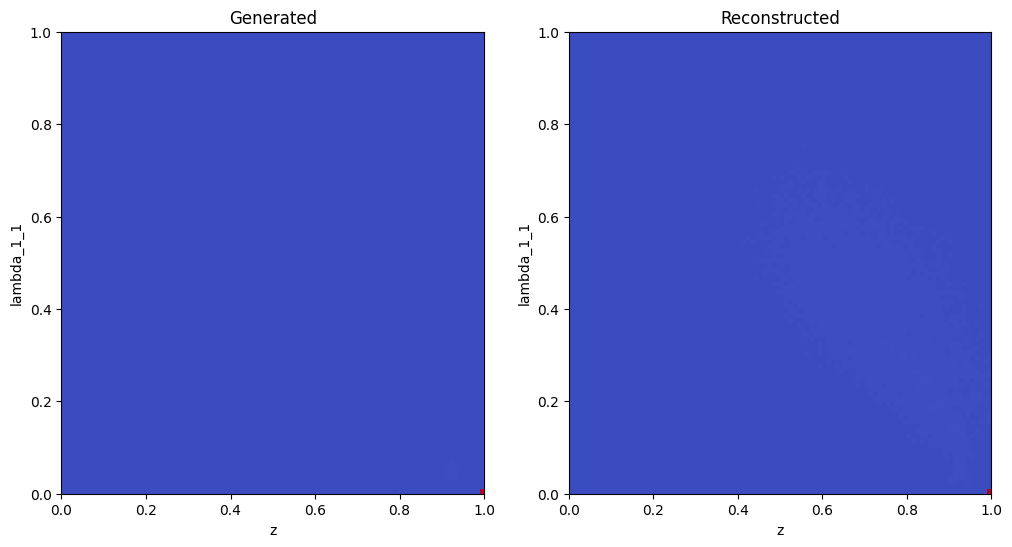

In [10]:
# plot 2d histograms of z versus lamda_1_1
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist2d(trainGen["z"], trainGen["lambda_1_1"], bins=100, cmap="coolwarm", range=[[0, 1], [0, 1]])
ax[0].set_title("Generated")
ax[0].set_xlabel("z")
ax[0].set_ylabel("lambda_1_1")
ax[1].hist2d(trainReco["z"], trainReco["lambda_1_1"], bins=100, cmap="coolwarm", range=[[0, 1], [0, 1]])
ax[1].set_title("Reconstructed")
ax[1].set_xlabel("z")
ax[1].set_ylabel("lambda_1_1")
plt.show()



In [11]:
# Processed MC reco data for training

X_det = np.concatenate((trainReco[features],testReco[features]))
# labels0 = {0}, labels_unknown = {1} 
Y_det = np.concatenate((np.zeros(trainReco.shape[0]),np.ones(testReco.shape[0])))

# Processed MC truth data data for training
X_gen = np.concatenate((trainGen[features], trainGen[features]))
Y_gen = np.concatenate((np.zeros(trainGen.shape[0]), np.ones(trainGen.shape[0])))

# Push and pull weights in unfolding
weights = np.empty(shape=(iterations, 2, len(trainReco)))
# shape = (#iteration, #step, #event)

# Normalization layer for input variables
normalizerLayer = tf.keras.layers.Normalization()
normalizerLayer.adapt(pd.concat([trainReco[features], testReco[features]]))


# tensorflow DNN model 
inputs = Input(len(features)) #  vector of number of features as input
normalized_layer = normalizerLayer(inputs)
# three hidden layers 
hidden_layer_1 = Dense(100, activation='relu')(normalized_layer)
dropout_1 = tf.keras.layers.Dropout(dropout_rate)(hidden_layer_1)
hidden_layer_2 = Dense(100, activation='relu')(dropout_1)
dropout_2 = tf.keras.layers.Dropout(dropout_rate)(hidden_layer_2)
hidden_layer_3 = Dense(100, activation='relu')(dropout_2)
dropout_3 = tf.keras.layers.Dropout(dropout_rate)(hidden_layer_3)
outputs = Dense(1, activation='sigmoid') (dropout_3)
model = Model(inputs=inputs, outputs=outputs)

# Early stopping criteria to avoid overtraining
earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              # restore_best_weights=True
                            )


In [12]:
print ("X_det: ", X_det.shape)
print ("Y_det: ", Y_det.shape)

print ("X_gen: ", X_gen.shape)
print ("Y_gen: ", Y_gen.shape)

print (trainReco[features].shape,testReco[features].shape)

print ("ratio of exp to sim: ", len(testReco)/len(trainReco))


X_det:  (500922, 6)
Y_det:  (500922,)
X_gen:  (751384, 6)
Y_gen:  (751384,)
(375692, 6) (125230, 6)
ratio of exp to sim:  0.3333315588301055


In [13]:
trainWts = trainGen["Weight"]
trainWts = trainWts/trainWts.mean()
trainWts = np.ones(len(trainWts))
print("Sum of training weights: ", trainWts.sum())

testWts = testReco["Weight"]
# testWts = testWts/testWts.mean()
print("Sum of testing weights: ", testWts.sum())

ndata, nsim = np.count_nonzero(Y_det), np.count_nonzero(Y_det==0)

trainWts= (ndata/nsim)*trainWts
if isClosureTest:
  testWts = np.ones(ndata)

#  reweight the sim and data to have the same total weight to begin with
print ("ndata = ", ndata)
print ("nsim = ", nsim)

# # Push and pull weights in unfolding
# # initial iterative weights are the nominal weight
weights_pull = trainWts
weights_push = trainWts

w_data = testWts


print(np.sum(testWts), np.sum(trainWts))


Sum of training weights:  375692.0
Sum of testing weights:  1282.4231829834475
ndata =  125230
nsim =  375692
1282.4231829834475 125229.9999999999


In [14]:
testWts

32579     0.025906
215274    0.013398
208977    0.031757
207933   -0.007851
152134   -0.000409
            ...   
190058    0.002650
216598   -0.001481
181900    0.070119
39357     0.044277
232609    0.013692
Name: Weight, Length: 125230, dtype: float64

In [15]:
trainWts

array([0.33333156, 0.33333156, 0.33333156, ..., 0.33333156, 0.33333156,
       0.33333156])

In [16]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=5*2000)
    weights = f / (1. - f + 1e-50)
    return np.squeeze(np.nan_to_num(weights, posinf=1, neginf=0, nan=1))    
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 
    
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    # weights_push = weights from previous interation
    # w_data is the "real" data
    weights_det = np.concatenate((weights_push,w_data))

    X_train_det, X_test_det, Y_train_det, Y_test_det, w_train_det, w_test_det = train_test_split(
        X_det, Y_det, weights_det)

    model.compile(loss= 'binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy']
                #   weighted_metrics=['accuracy']
    )
    # Classification at reco level
    model.fit(X_train_det, 
              Y_train_det,
              sample_weight=w_train_det,
              epochs=200,
              batch_size=5*2000,
              validation_data=(X_test_det, Y_test_det, w_test_det),
              callbacks=[earlystopping],
              verbose=1)

    # reco events weights after reco level reweight
    weights_pull = weights_push * reweight(trainReco[features])
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    # "Signal" is MC truth events after reco level reweight, "background" is the un-weighted true MC events

    weights_model = np.concatenate(( trainWts,weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_model, X_test_model, Y_train_model, Y_test_model, w_train_model, w_test_model = train_test_split(
        X_gen, Y_gen, weights_model)

    model.compile(loss= 'binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_model,
              Y_train_model,
              sample_weight=w_train_model,
              epochs=200,
              batch_size=5*2000,
              validation_data=(X_test_model, Y_test_model, w_test_model),
              callbacks=[earlystopping],
              verbose=1)

    # weights after truth level reweight
    weights_push = trainWts*reweight(trainGen[features])
    ### 
    
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200
38/38 [==============================] - 2s 26ms/step - loss: 0.0588 - accuracy: 0.7462 - val_loss: 0.0202 - val_accuracy: 0.7521
Epoch 2/200
38/38 [==============================] - 1s 27ms/step - loss: 0.0194 - accuracy: 0.7493 - val_loss: 0.0180 - val_accuracy: 0.7521
Epoch 3/200
38/38 [==============================] - 1s 27ms/step - loss: 0.0178 - accuracy: 0.7493 - val_loss: 0.0169 - val_accuracy: 0.7521
Epoch 4/200
38/38 [==============================] - 1s 26ms/step - loss: 0.0167 - accuracy: 0.7493 - val_loss: 0.0157 - val_accuracy: 0.7521
Epoch 5/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0155 - accuracy: 0.7493 - val_loss: 0.0146 - val_accuracy: 0.7521
Epoch 6/200
38/38 [==============================] - 1s 26ms/step - loss: 0.0147 - accuracy: 0.7493 - val_loss: 0.0141 - val_accuracy: 0.7521
Epoch 7/200
38/38 [==============================] - 1s 24ms/step - loss: 0.0143 - accuracy: 0.7493 - val_loss: 0.0138 - val_

/tmp/ipykernel_137911/4185977404.py:4: RuntimeWarning: divide by zero encountered in divide
  weights = f / (1. - f + 1e-50)



STEP 2

Epoch 1/200
57/57 [==============================] - 2s 29ms/step - loss: 0.3413 - accuracy: 0.4997 - val_loss: 0.0457 - val_accuracy: 0.5009
Epoch 2/200
57/57 [==============================] - 2s 29ms/step - loss: 0.0244 - accuracy: 0.4997 - val_loss: 0.0247 - val_accuracy: 0.5009
Epoch 3/200
57/57 [==============================] - 2s 29ms/step - loss: 0.0162 - accuracy: 0.4997 - val_loss: 0.0169 - val_accuracy: 0.5009
Epoch 4/200
57/57 [==============================] - 2s 29ms/step - loss: 0.0107 - accuracy: 0.4997 - val_loss: 0.0129 - val_accuracy: 0.5009
Epoch 5/200
57/57 [==============================] - 2s 31ms/step - loss: 0.0100 - accuracy: 0.4997 - val_loss: 0.0123 - val_accuracy: 0.5009
Epoch 6/200
57/57 [==============================] - 2s 36ms/step - loss: 0.0099 - accuracy: 0.4997 - val_loss: 0.0118 - val_accuracy: 0.5009
Epoch 7/200
57/57 [==============================] - 2s 30ms/step - loss: 0.0099 - accuracy: 0.4997 - val_loss: 0.0111 - val_accuracy: 0.50

/tmp/ipykernel_137911/4185977404.py:4: RuntimeWarning: divide by zero encountered in divide
  weights = f / (1. - f + 1e-50)



STEP 2

Epoch 1/200
57/57 [==============================] - 2s 25ms/step - loss: 336038.3438 - accuracy: 0.5001 - val_loss: 5500.9272 - val_accuracy: 0.4997
Epoch 2/200
57/57 [==============================] - 2s 27ms/step - loss: 174704.8594 - accuracy: 0.5001 - val_loss: 5076.2632 - val_accuracy: 0.4997
Epoch 3/200
57/57 [==============================] - 2s 30ms/step - loss: 175880.6719 - accuracy: 0.5001 - val_loss: 4821.5767 - val_accuracy: 0.4997
Epoch 4/200
57/57 [==============================] - 2s 28ms/step - loss: 47540.7891 - accuracy: 0.5001 - val_loss: 4462.9448 - val_accuracy: 0.4997
Epoch 5/200
57/57 [==============================] - 2s 28ms/step - loss: 82157.7500 - accuracy: 0.5001 - val_loss: 4095.5012 - val_accuracy: 0.4997
Epoch 6/200
57/57 [==============================] - 2s 29ms/step - loss: 61382.8359 - accuracy: 0.5001 - val_loss: 3715.9346 - val_accuracy: 0.4997
Epoch 7/200
57/57 [==============================] - 2s 29ms/step - loss: 38387.4258 - accurac

/tmp/ipykernel_137911/4185977404.py:4: RuntimeWarning: divide by zero encountered in divide
  weights = f / (1. - f + 1e-50)



ITERATION: 3

STEP 1

Epoch 1/200
38/38 [==============================] - 2s 28ms/step - loss: -932.1357 - accuracy: 0.4200 - val_loss: -1619.5529 - val_accuracy: 0.7513
Epoch 2/200
38/38 [==============================] - 1s 29ms/step - loss: -1006.2117 - accuracy: 0.6672 - val_loss: -1648.7047 - val_accuracy: 0.7513
Epoch 3/200
38/38 [==============================] - 1s 25ms/step - loss: -978.8242 - accuracy: 0.6626 - val_loss: -1667.3334 - val_accuracy: 0.7513
Epoch 4/200
38/38 [==============================] - 1s 27ms/step - loss: -1008.0259 - accuracy: 0.6613 - val_loss: -1725.1031 - val_accuracy: 0.7513
Epoch 5/200
38/38 [==============================] - 1s 25ms/step - loss: -1075.1339 - accuracy: 0.6616 - val_loss: -1762.4434 - val_accuracy: 0.7513
Epoch 6/200
38/38 [==============================] - 1s 25ms/step - loss: -1095.1658 - accuracy: 0.6608 - val_loss: -1779.2484 - val_accuracy: 0.7513
Epoch 7/200
38/38 [==============================] - 1s 29ms/step - loss: -1083

KeyboardInterrupt: 

In [ ]:
# import omnifold_new as of
# import importlib
# importlib.reload(of)

# weights = of.omnifold(trainGen[features], trainReco[features], testReco[features], trainWts, testWts, iterations, model,1)


In [ ]:
# # undo feature scaling
# testReco["pt"] = np.exp(testReco["pt"])-1 + min_pt
# trainReco["pt"] = np.exp(trainReco["pt"])-1 + min_pt

In [17]:
np.save(f"{saveFolder}/weights.npy", weights)

In [18]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 240
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})
# a dictionary to hold information about the observables
obs = {}
# the jet mass and histogram style information
obs.setdefault('pt', {}).update({
    # 'bins_mc':[1,3,5,7,10,13,20,30],
    # 'bins_det':[-10,-5,-1,1,3,5,7,10,13,16,20,30,40],
    #  TO DO binning from Ondra with > 10 counts
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (1, 30), 
    'ylim': (1e-7, 1),
    'xlim_det': (-10, 40),
    'xlabel': r'Jet $p_{t}$  [GeV/c]', 'symbol': r'$p_{t}$',
    'ylabel': r'Counts', 'yscale': 'log',
    'stamp_xy': (0.2, 0.25),
    'legend_loc': 'upper right'
})

# the groomed momentum fraction and histogram style information
obs.setdefault('z', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0.1, 1.001), 
    'ylim': (1e-4, 10),
    'xlim_det': (-15, 15),
    'xlabel': r'Jet Momentum Fraction $z$', 'symbol': r'$z$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.65), 
    'xlim_det': (-15, 15),   
    'xlabel': r'Jet Angularity $\lambda_{1}^{1}$', 'symbol': r'$lambda_1_1$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('lambda_1_1half', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.35),
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 'symbol': r'$lambda_1_1half$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('lambda_1_2', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.15), 
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{2}$', 'symbol': r'$lambda_1_2$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('lambda_1_3', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.055), 
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{3}$', 'symbol': r'$lambda_1_3$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('eta', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (-0.6, 0.6),
    'xlim_det': (-0.6, 0.6),  
    'xlabel': r'Jet  $\eta$', 'symbol': r'$\eta$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('dispersion', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0.3, 1), 
    'xlim_det': (0, 20),  
    'xlabel': r'Jet Dispersion', 'symbol': r'$dispersion$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('area', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 1), 
    'xlim_det': (0, 1),  
    'xlabel': r'Jet Area', 'symbol': r'$area$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('nconst', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 100), 
    'xlim_det': (0, 200),  
    'xlabel': r'Jet Constituents', 'symbol': r'$nconst$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('lambda_1_half', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.35), 
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 'symbol': r'$lambda_1_half$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})




# additional histogram and plot style information
hist_style = {'histtype': 'step', 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '-', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
omnifold_style = {'ls': 'none', 'marker': 's', 'ms': 2.5, 'zorder': 3}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

import ibu

for obkey,ob in obs.items():
        # calculate observable for GEN, SIM, DATA
    ob['genobs'] = trainGen[obkey].to_numpy()
    ob['simobs'] = trainReco[obkey].to_numpy()

    ob['truthobs'] = testGen[obkey].to_numpy()
    ob['dataobs'] = testReco[obkey].to_numpy()

 # setup bins if they are not present
    if 'bins_det' not in ob:
        ob['bins_det'] = np.linspace(ob['xlim_det'][0], ob['xlim_det'][1], ob['nbins_det']+1)
    if 'bins_mc' not in ob:
        ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    
    ob['bins_det'] = np.array(ob['bins_det'])
    ob['bins_mc'] = np.array(ob['bins_mc'])

    # calculate midpoints of the bins 
    ob['midbins_det'] = 0.5*(ob['bins_det'][1:] + ob['bins_det'][:-1])
    ob['midbins_mc'] = 0.5*(ob['bins_mc'][1:] + ob['bins_mc'][:-1])

    # calculate widths of the bins
    ob['binwidth_det'] = ob['bins_det'][1:] - ob['bins_det'][:-1]
    ob['binwidth_mc'] = ob['bins_mc'][1:] - ob['bins_mc'][:-1]


    # get the histograms of GEN, DATA, and SIM level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'])[0]
    ob['simobs_hist'] = np.histogram(ob['simobs'], bins=ob['bins_det'])[0]
    ob['data_hist']   = np.histogram(ob['dataobs'], bins=ob['bins_det'])[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=False)[:2]

    # # compute (and normalize) the response matrix between GEN and SIM
    # ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    # ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # # perform iterative Bayesian unfolding
    # ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
    #                      ob['binwidth_det'], ob['binwidth_mc'], it=iterations)
    # ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=iterations, nresamples=25)
  
   
    print('Done with', obkey)
    

Done with pt
Done with z
Done with lambda_1_1
Done with lambda_1_1half
Done with lambda_1_2
Done with lambda_1_3
Done with eta
Done with dispersion
Done with area
Done with nconst
Done with lambda_1_half


In [19]:
selectedIteration = iterations - 1
selectedIteration = 1

/tmp/ipykernel_137911/735890373.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_137911/735890373.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


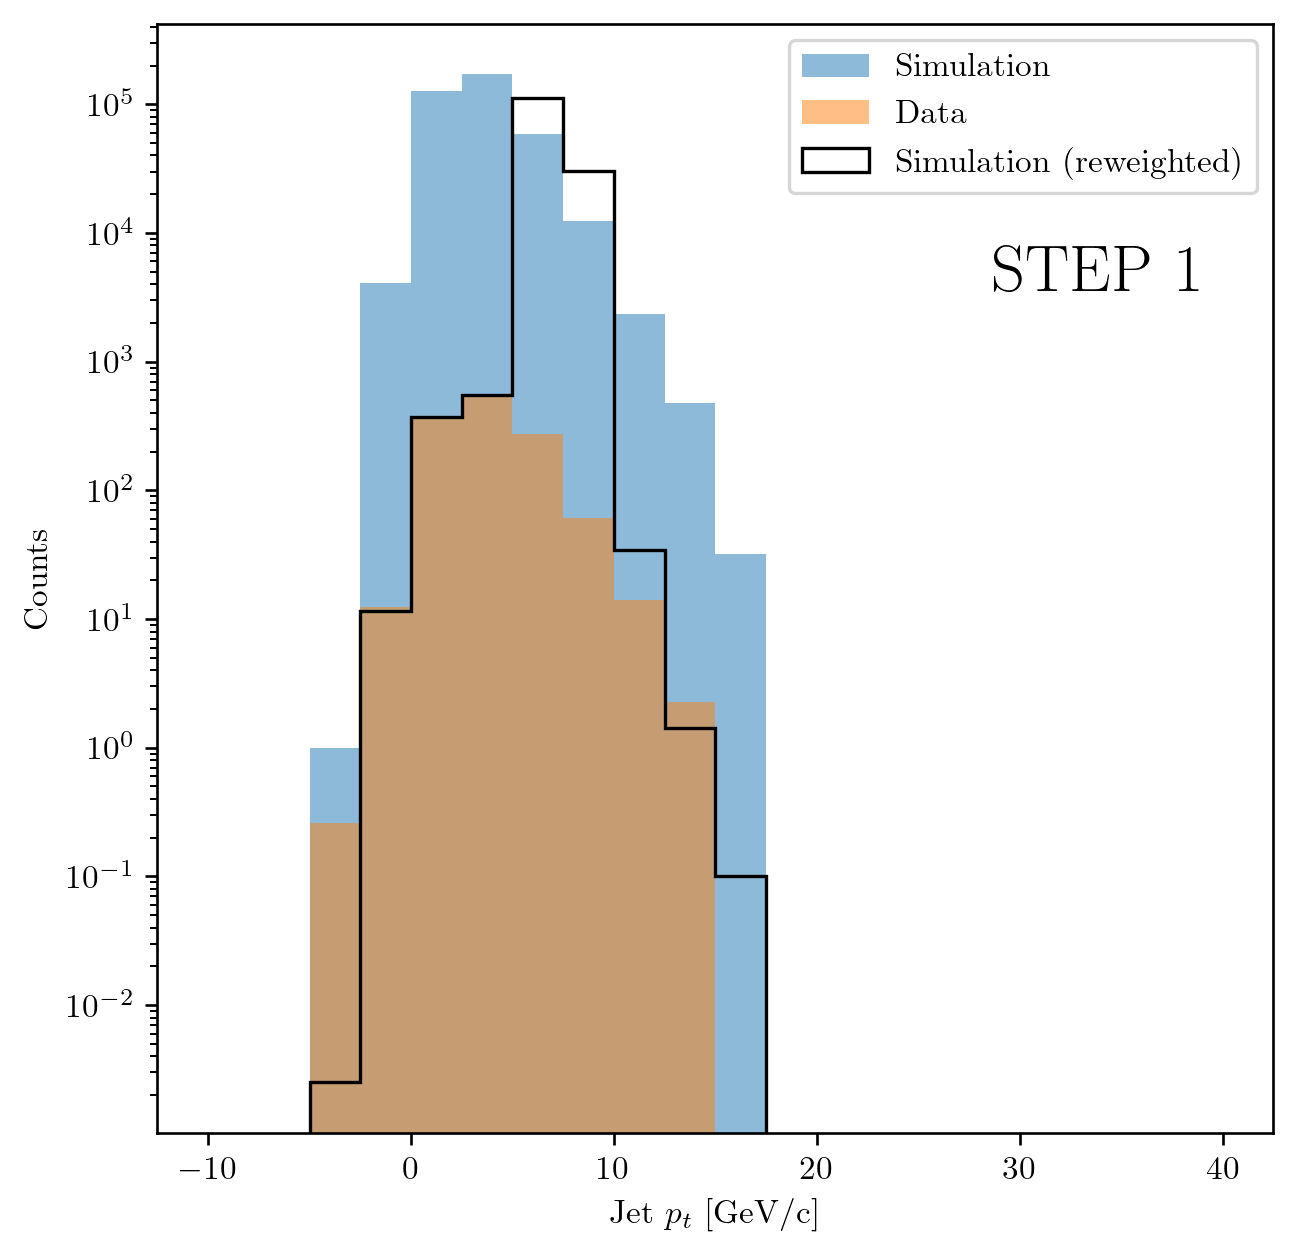

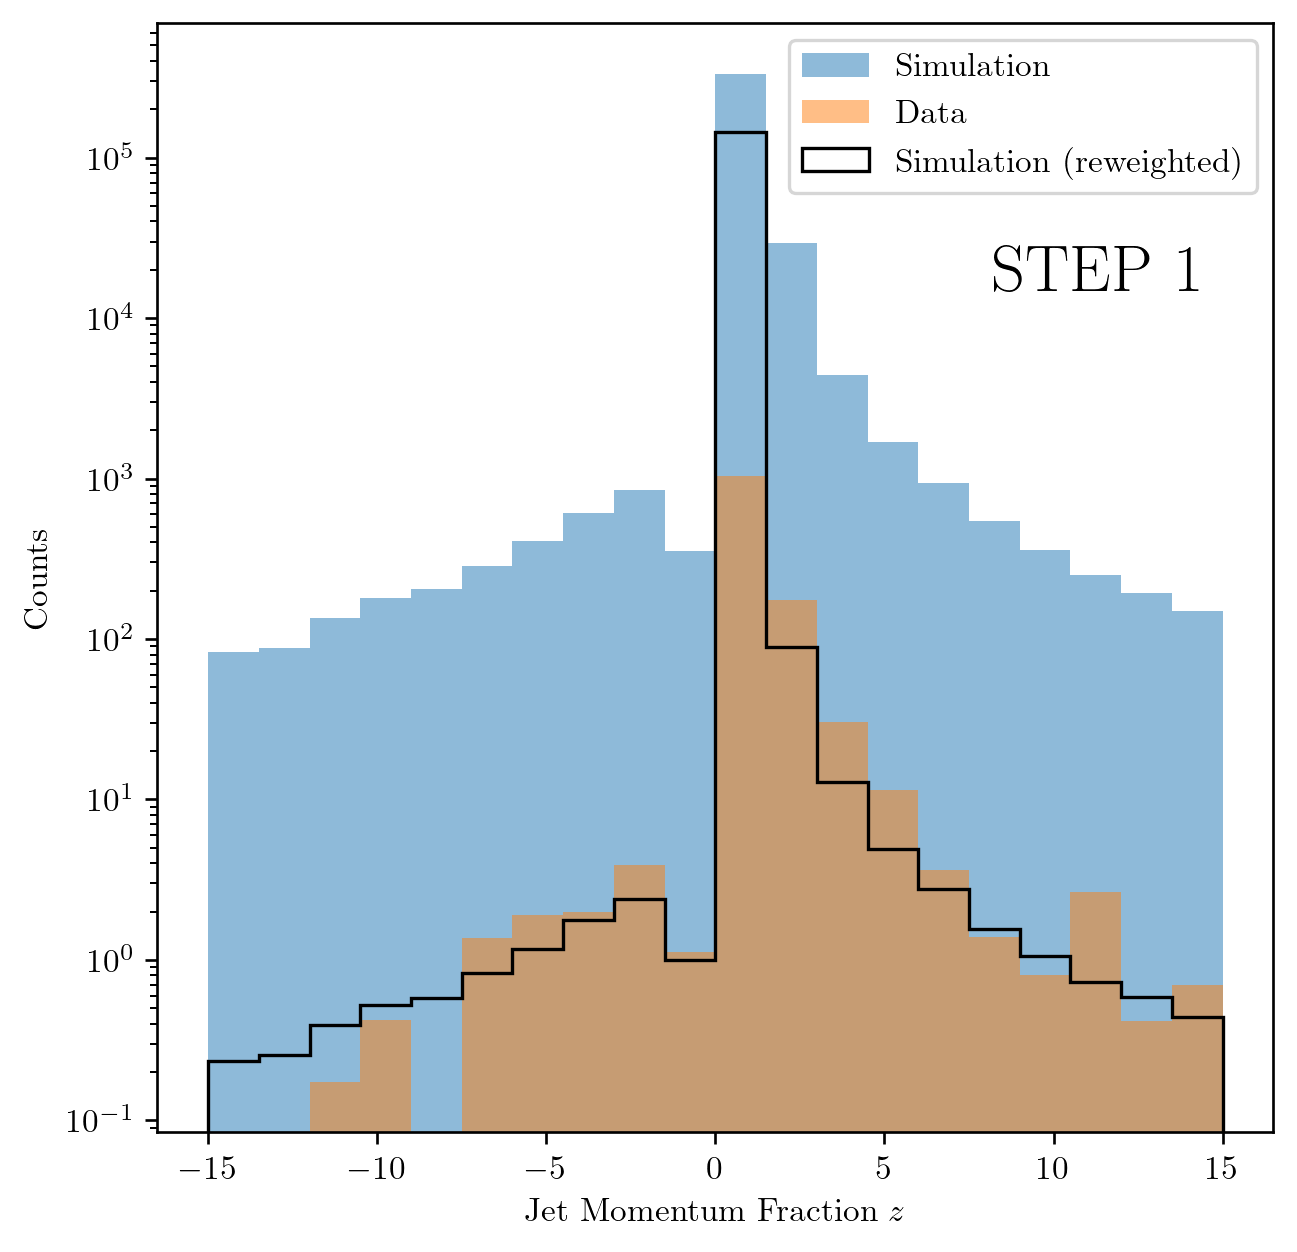

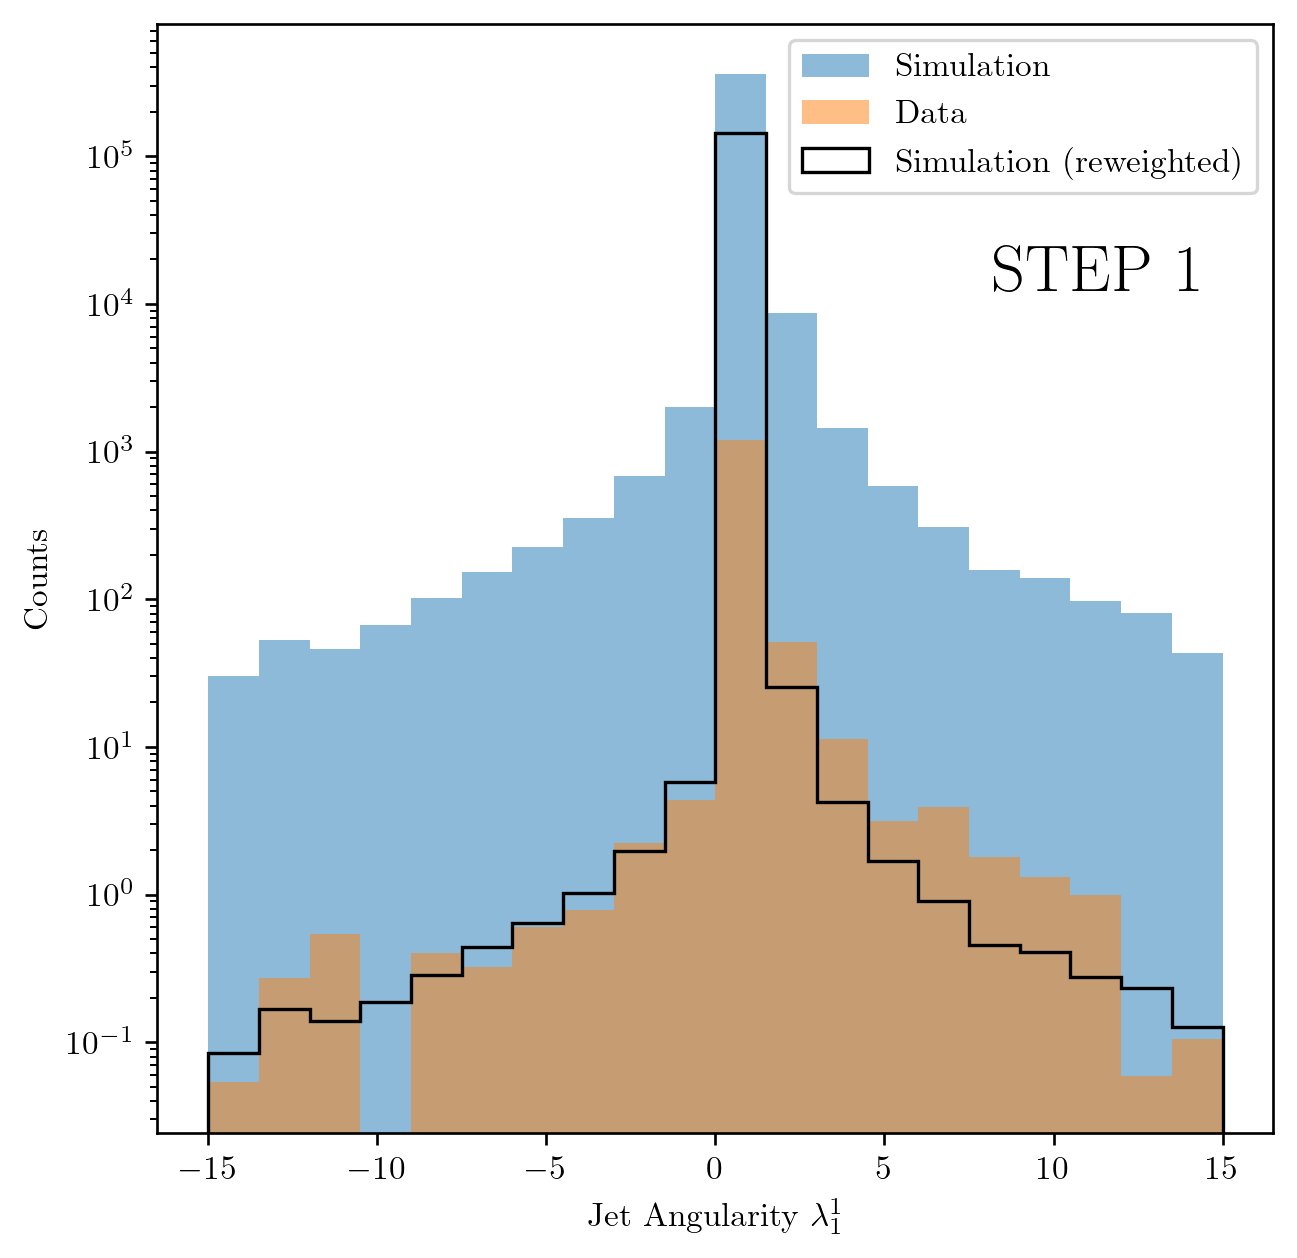

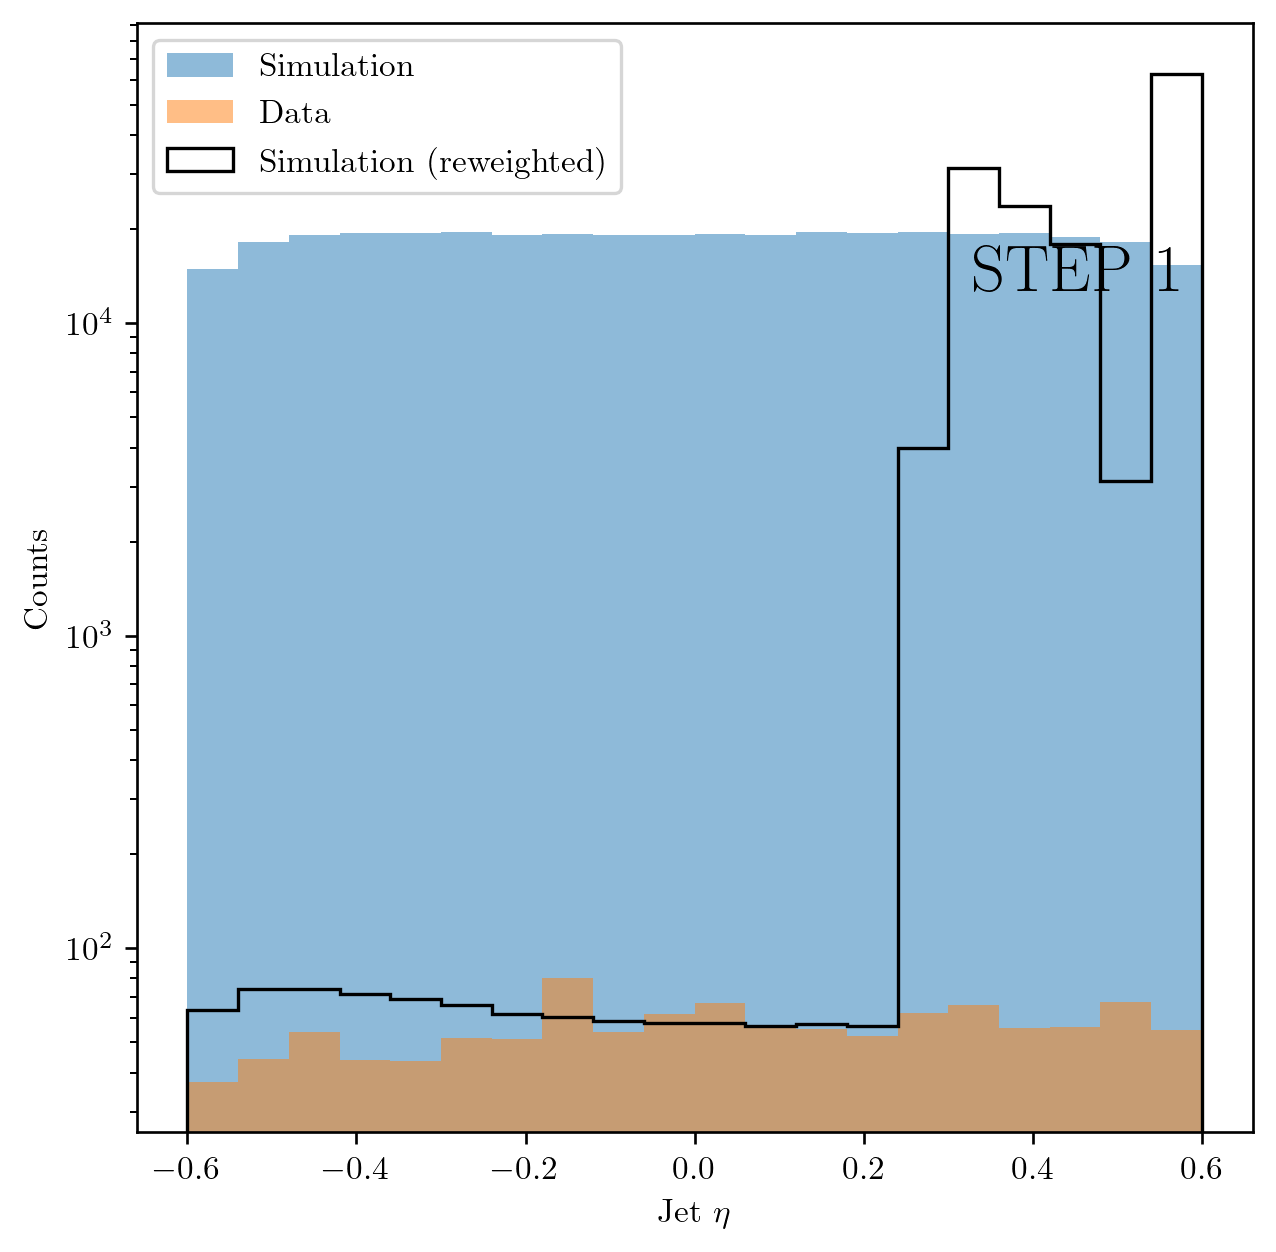

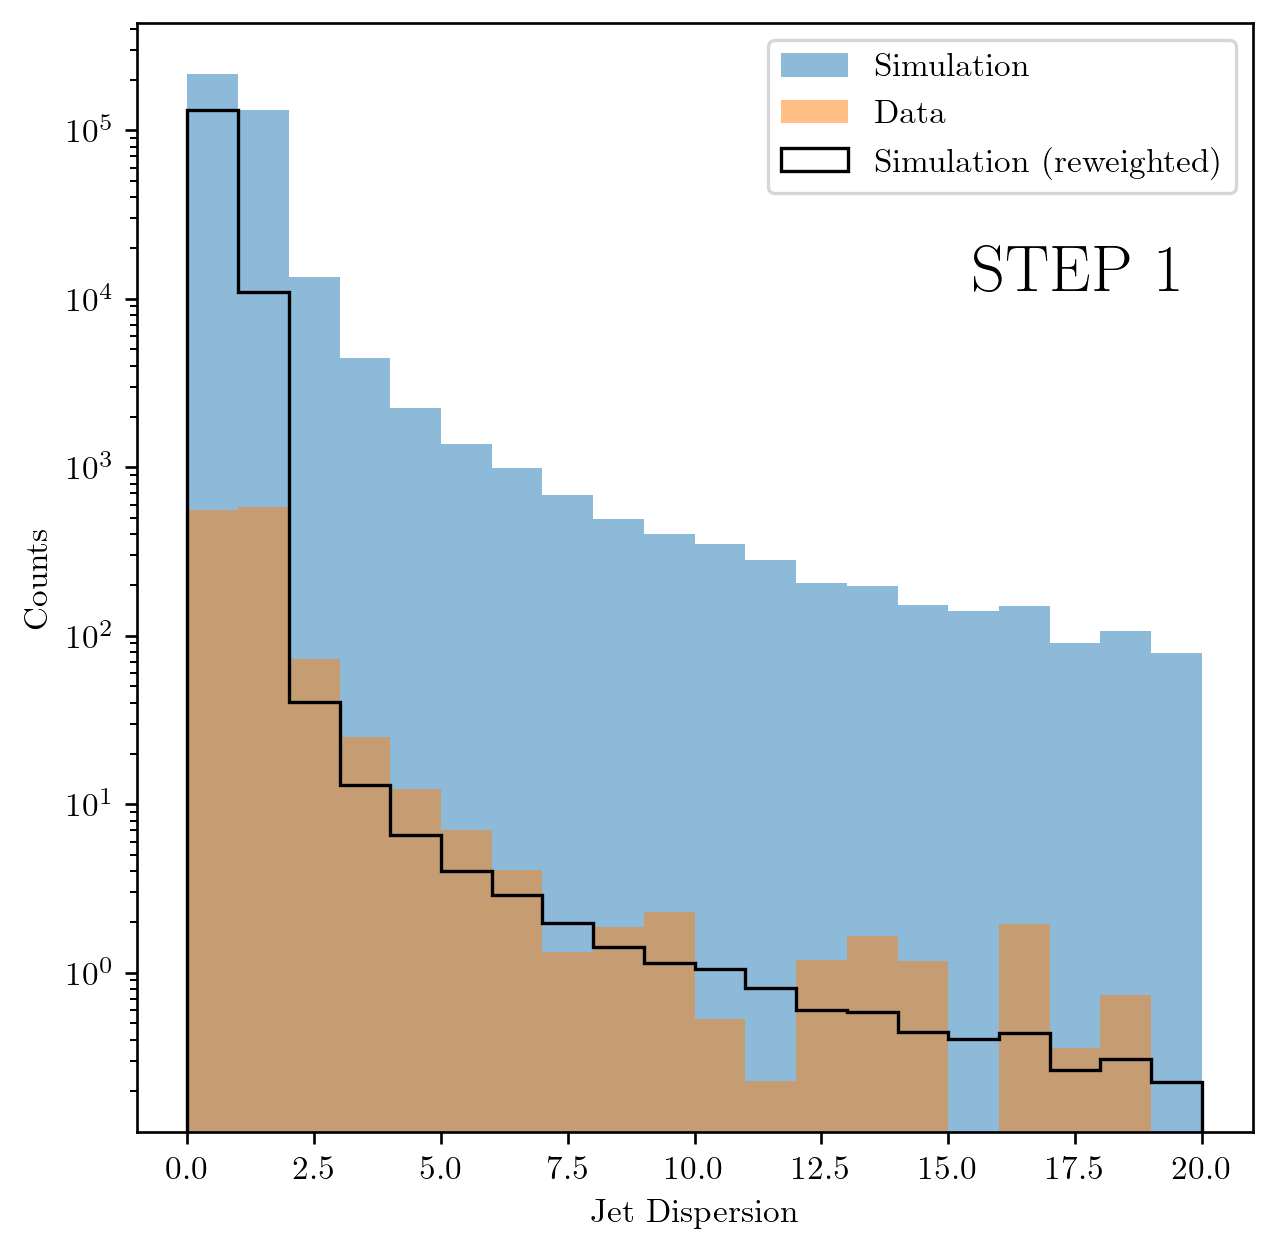

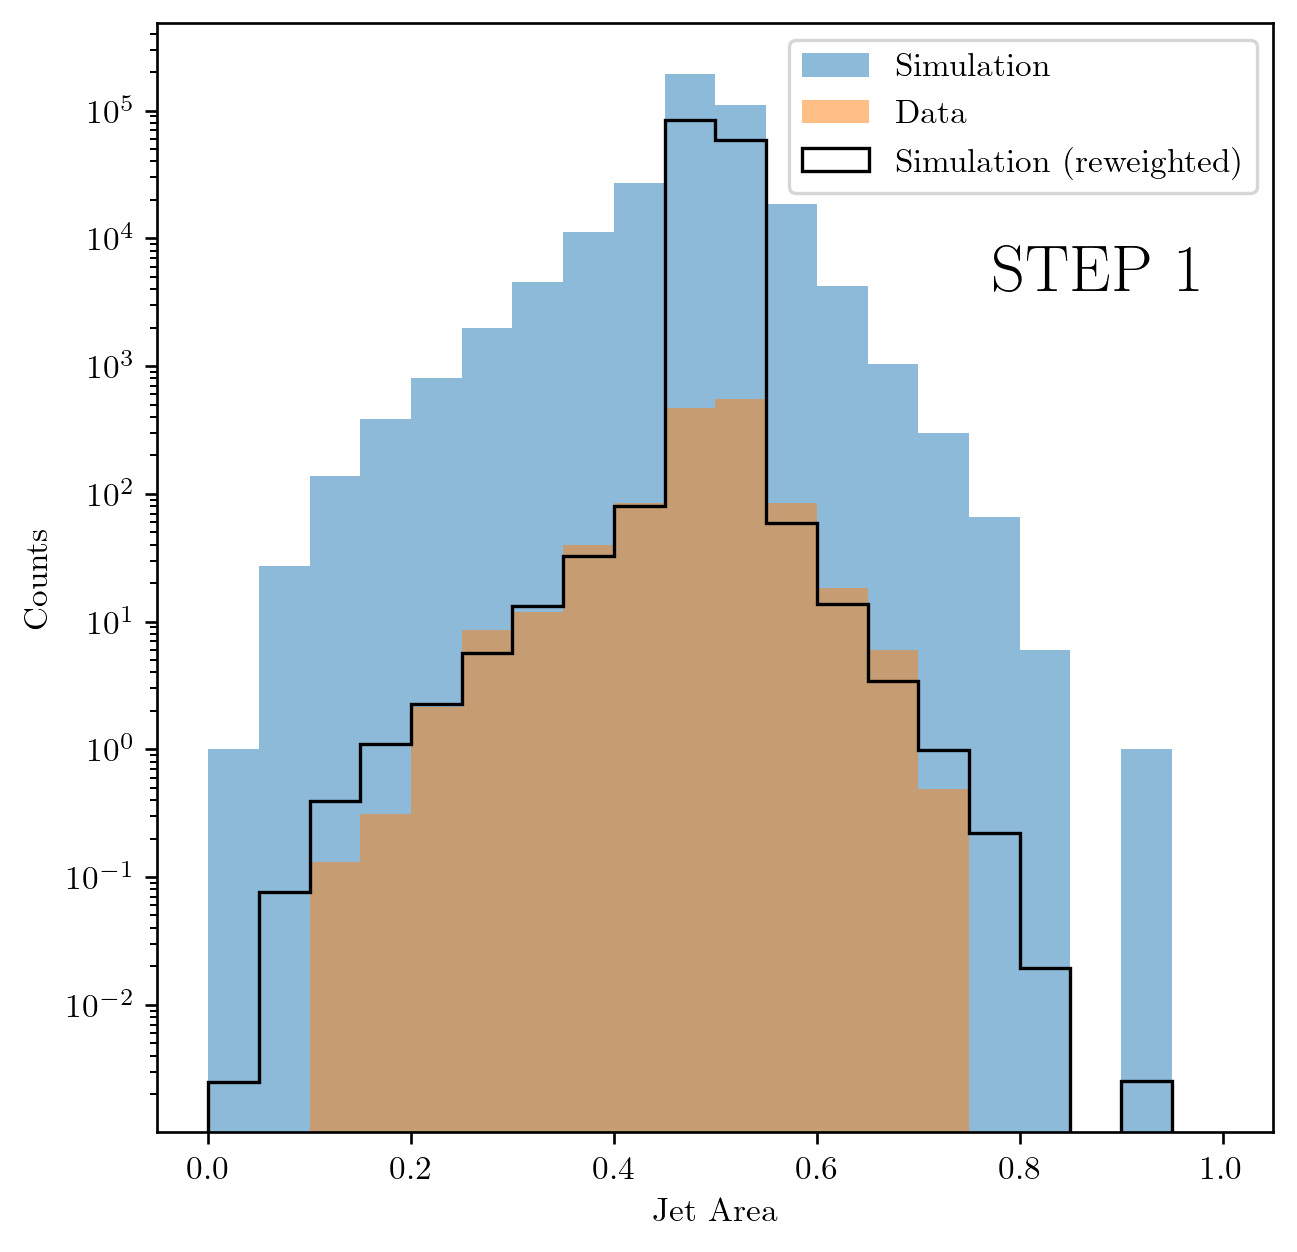

In [20]:
wdata = weights[selectedIteration,0,:] #weights after last iteration for pull after step 1

# for i,(obkey,ob) in enumerate(obs.items()):
# terate only in those observables which are in features:
for obkey,ob in obs.items():
    if obkey not in features:
        continue

    plt .rcParams['figure.figsize'] = (6,6)
    plt .rcParams['figure.dpi'] = 240

    fig, ax = plt.subplots()
    
    ax.hist(trainReco[obkey], bins=ob['bins_det']  , **plot_style_2, label='Simulation')
    ax.hist(testReco[obkey], bins=ob['bins_det'], **plot_style_2, label='Data ', weights=testWts)
    entries, edges, _ = ax.hist(trainReco[obkey], bins=ob['bins_det'], histtype="step", label='Simulation (reweighted)',color="black",weights=wdata)

    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    # draw errobars, use the sqrt error. You can use what you want there
    # poissonian 1 sigma intervals would make more sense
    # plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='k.')
    # legend = ax.legend(loc='upper left',    frameon=False)
    # plt.setp(legend.get_title(), multialignment='center')
    plt.yscale('log')
    plt.xlabel(ob['xlabel'])
    plt.ylabel(ob['ylabel'])
    plt.legend()

    #  add text "STEP 1"
    ax.text(0.75,0.8,"STEP 1", ha='left',va='top',transform=ax.transAxes, fontsize=20)
    
     

    fig.show()

    fig.savefig(f"{saveFolder}/reweight_{obkey}.pdf", bbox_inches='tight')

/tmp/ipykernel_137911/1627398787.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


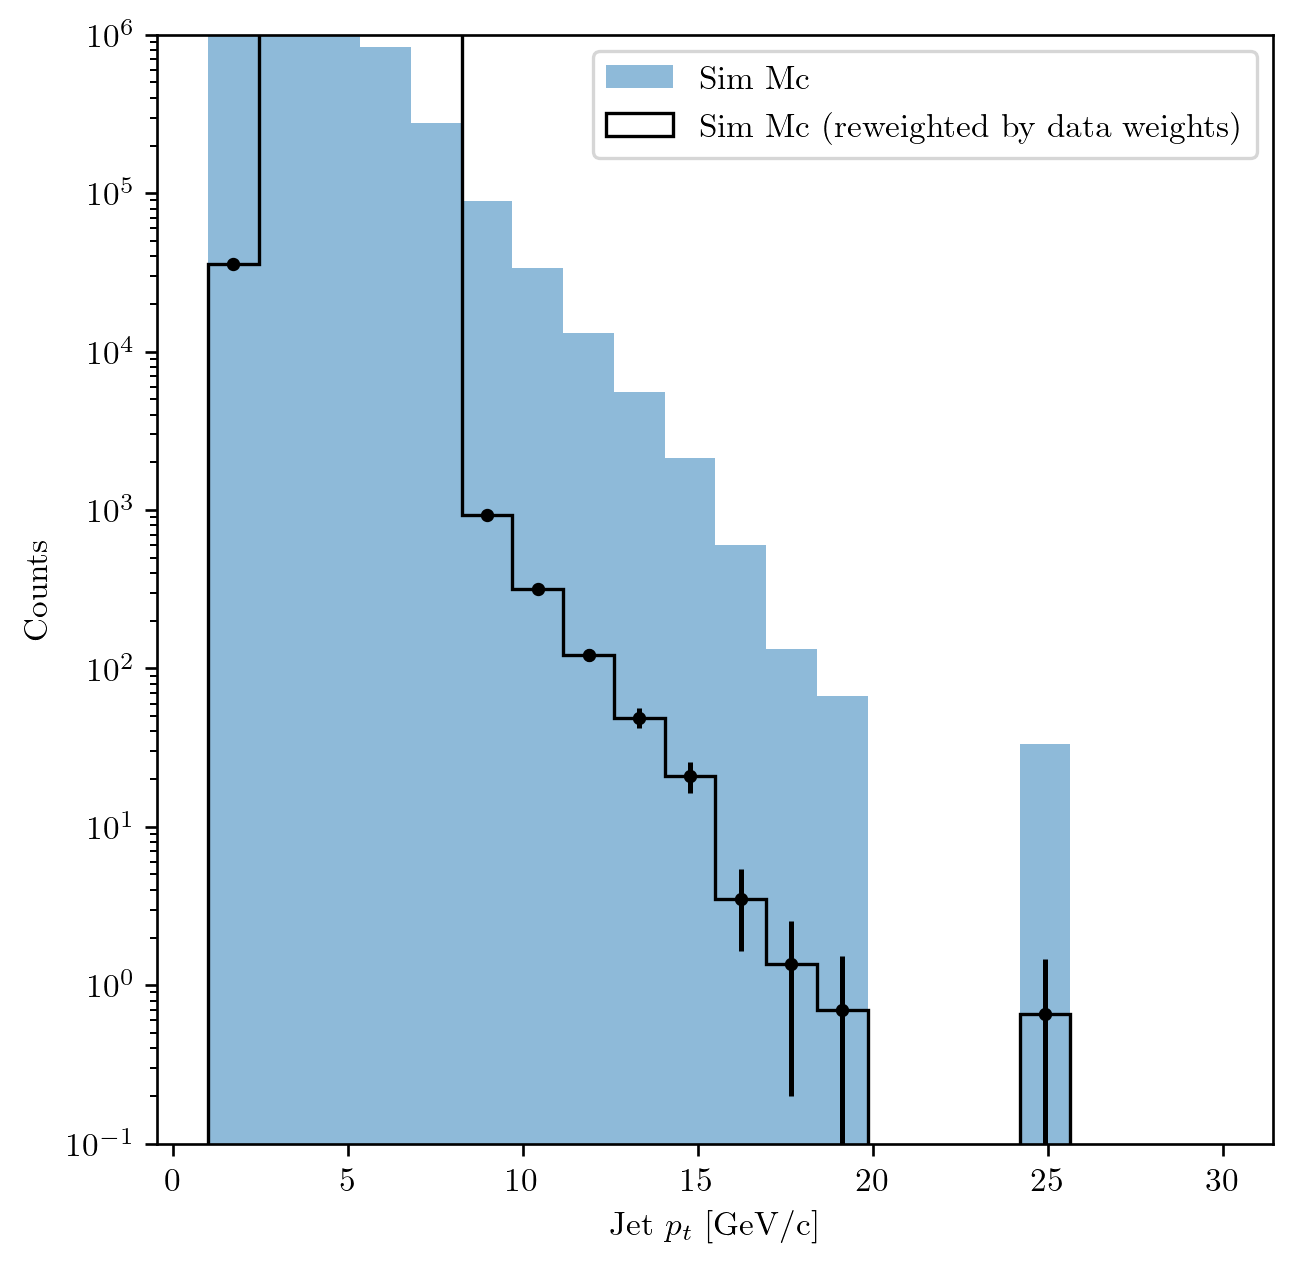

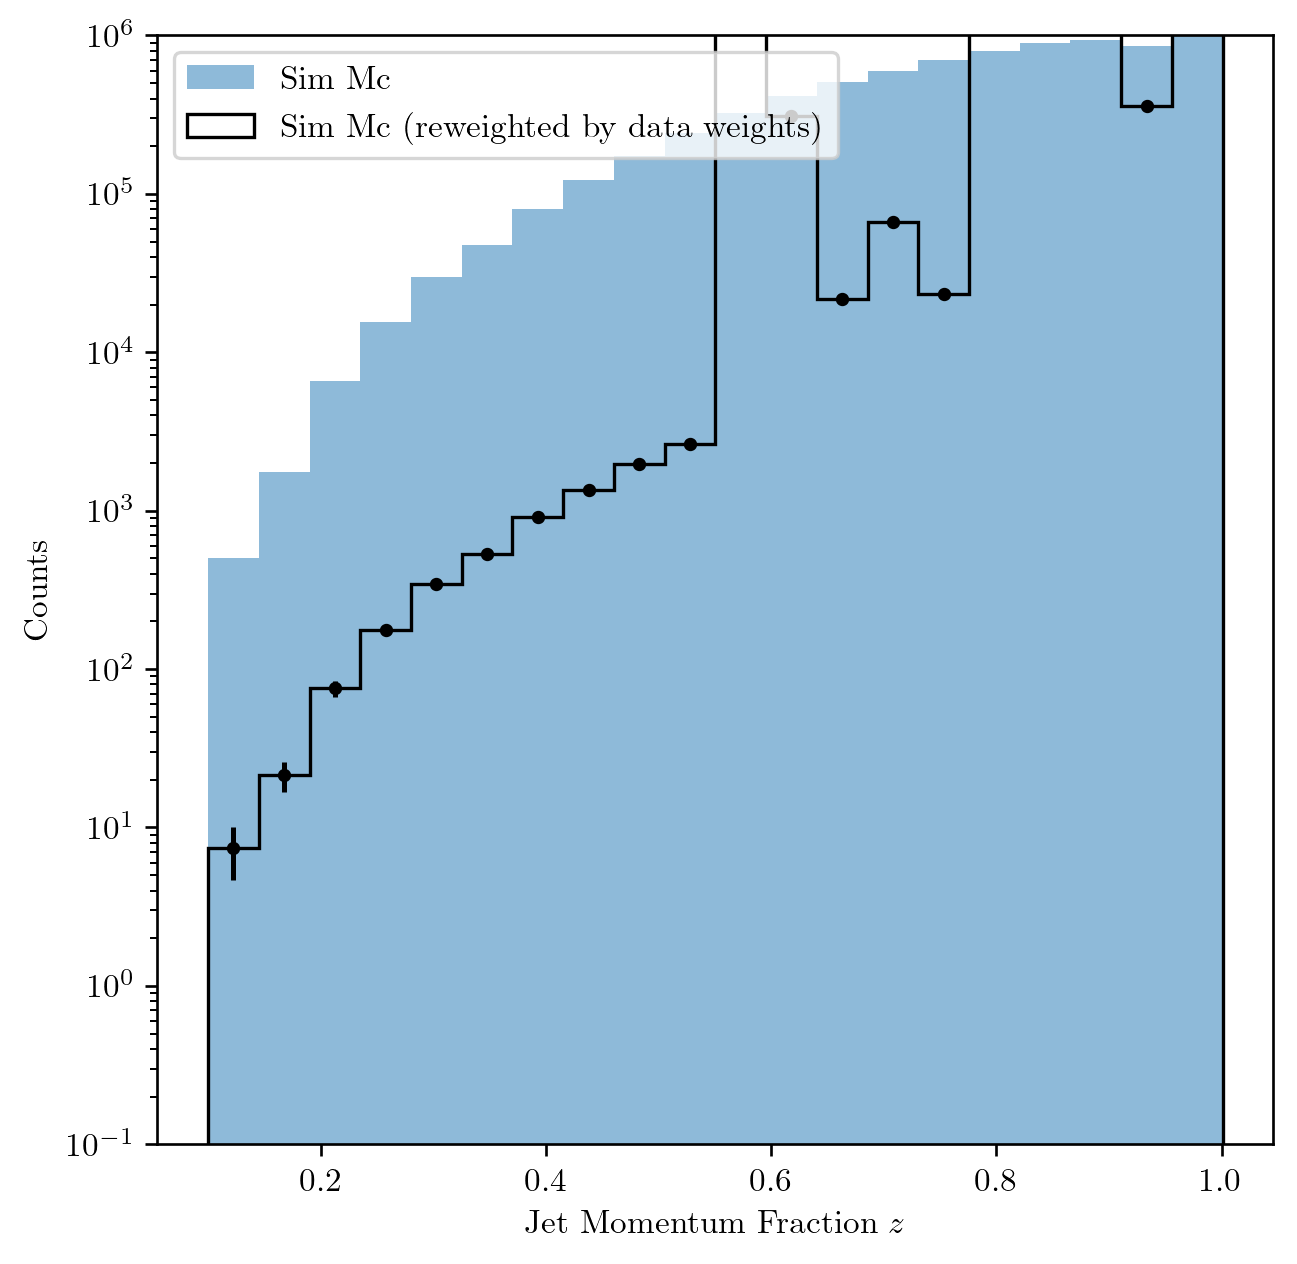

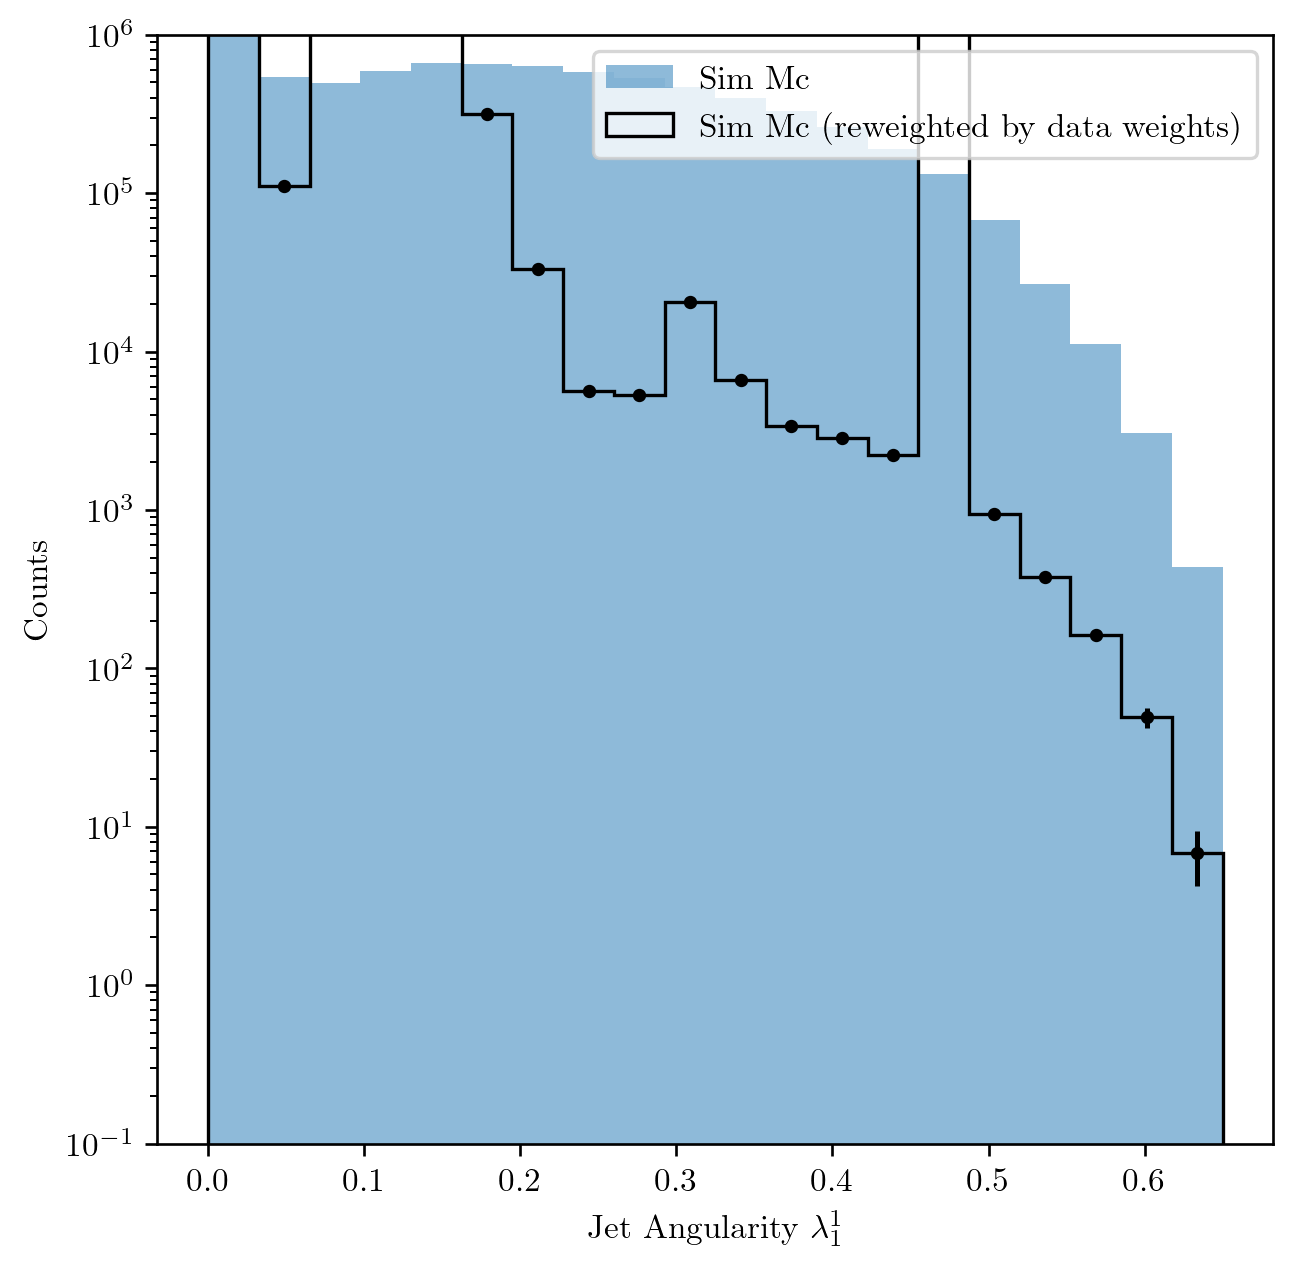

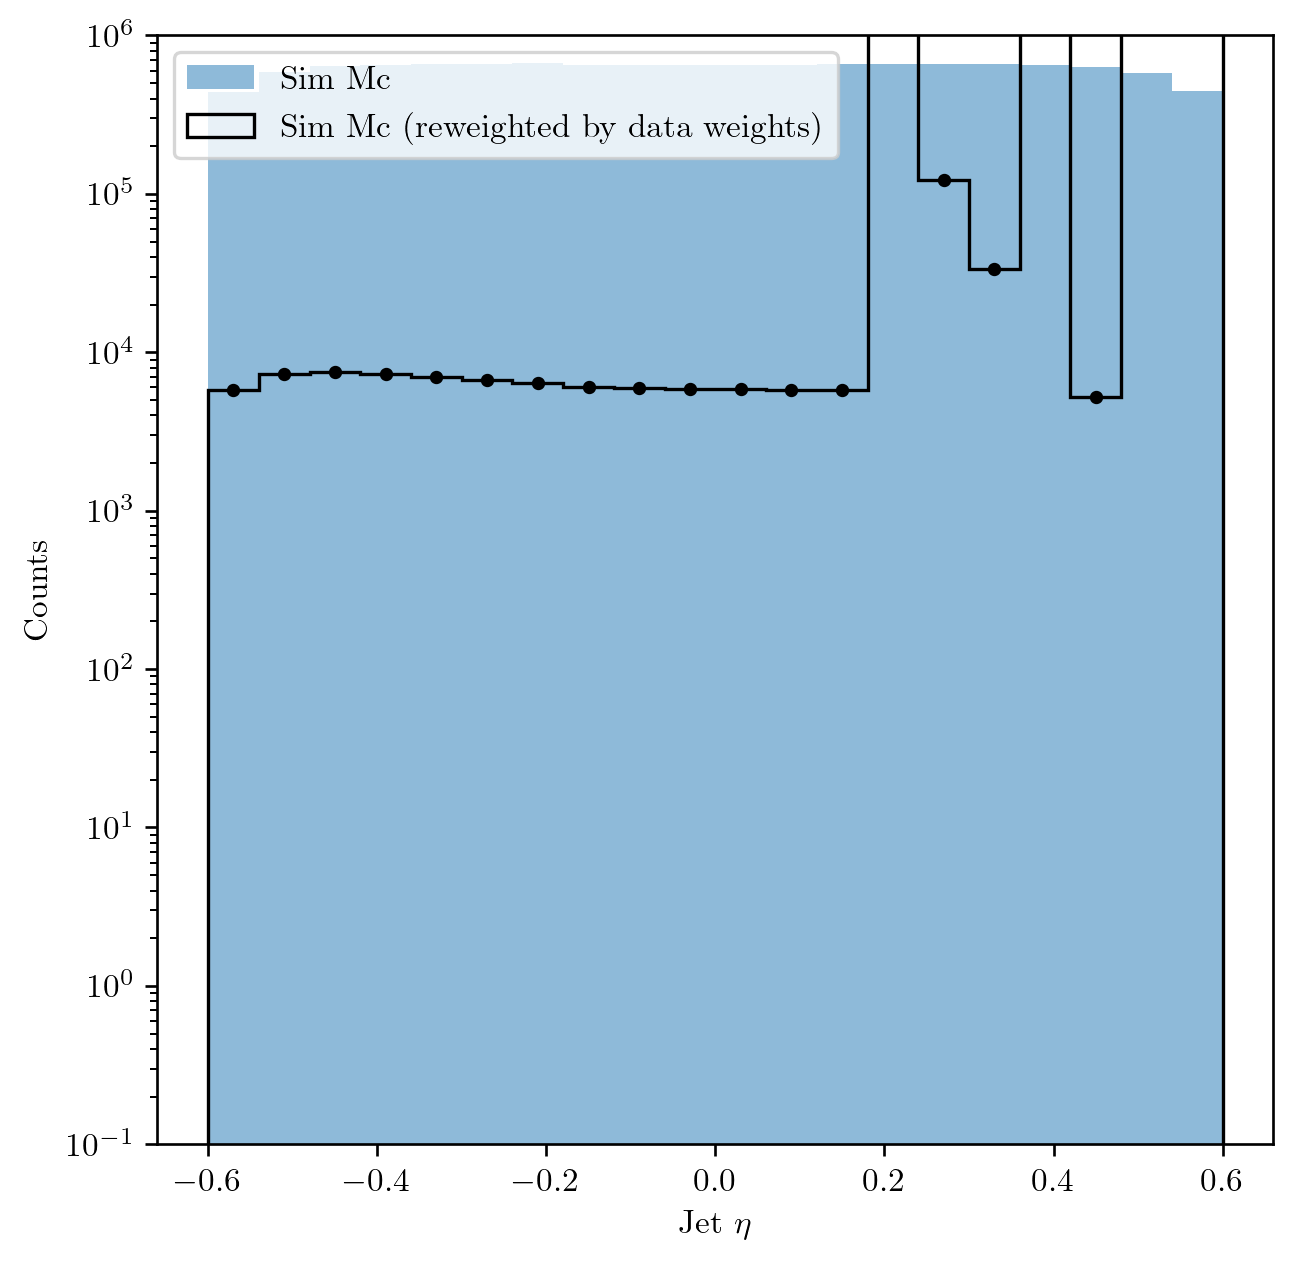

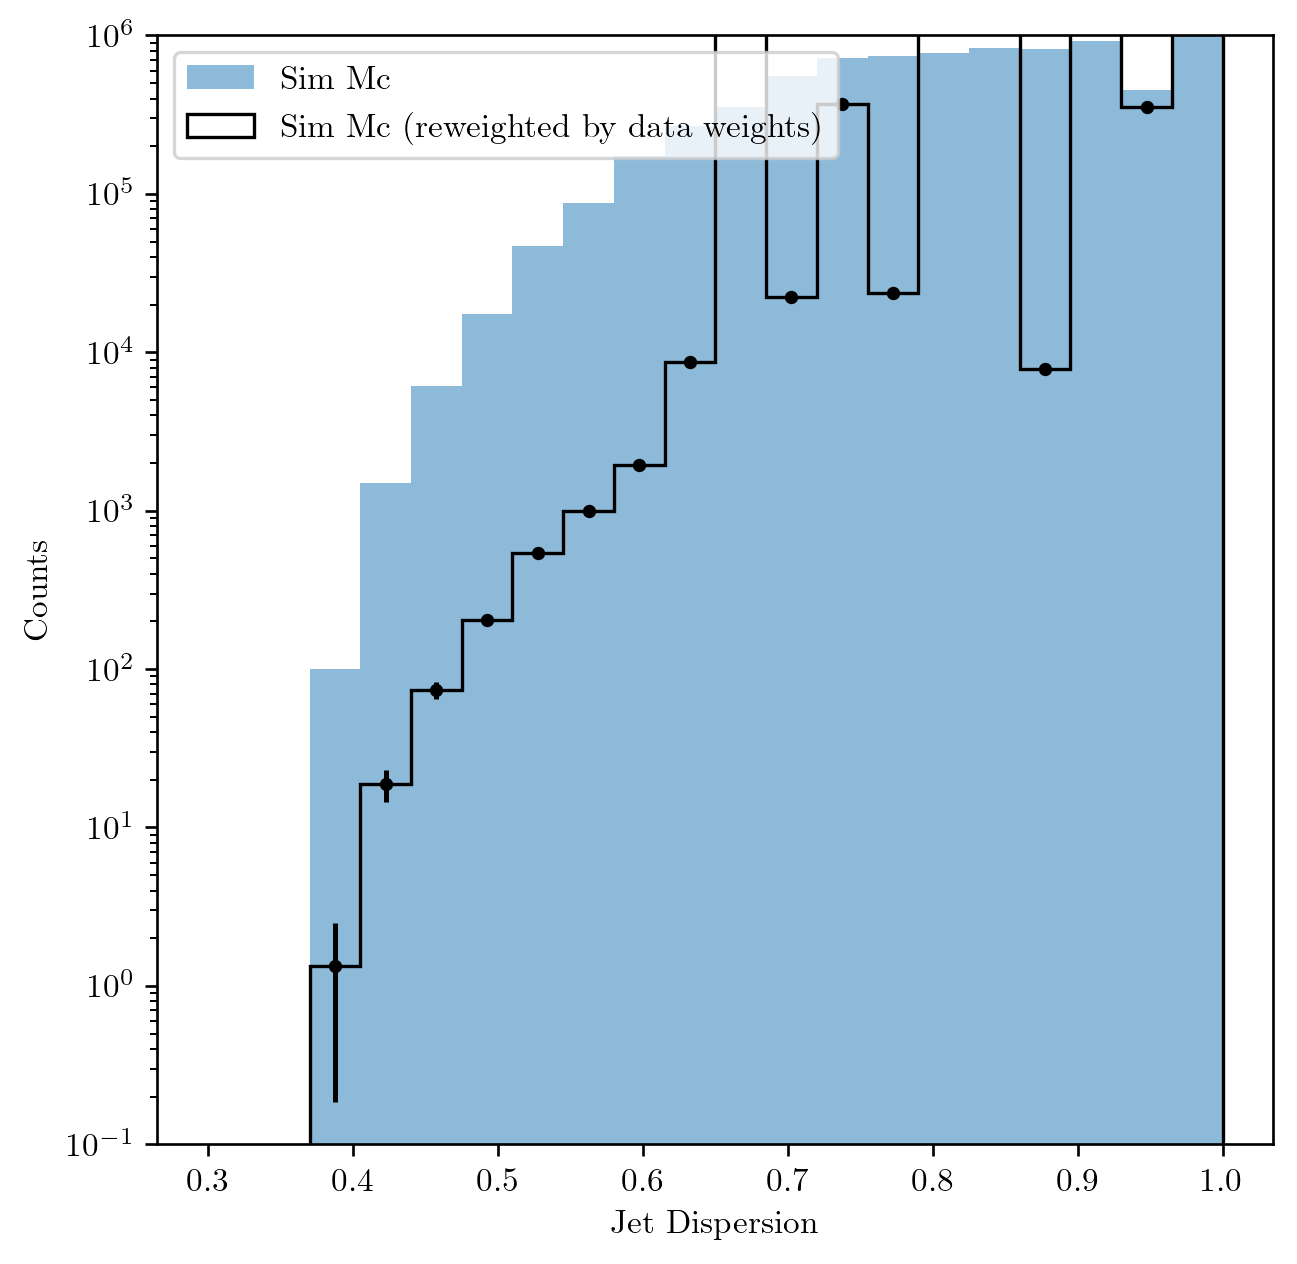

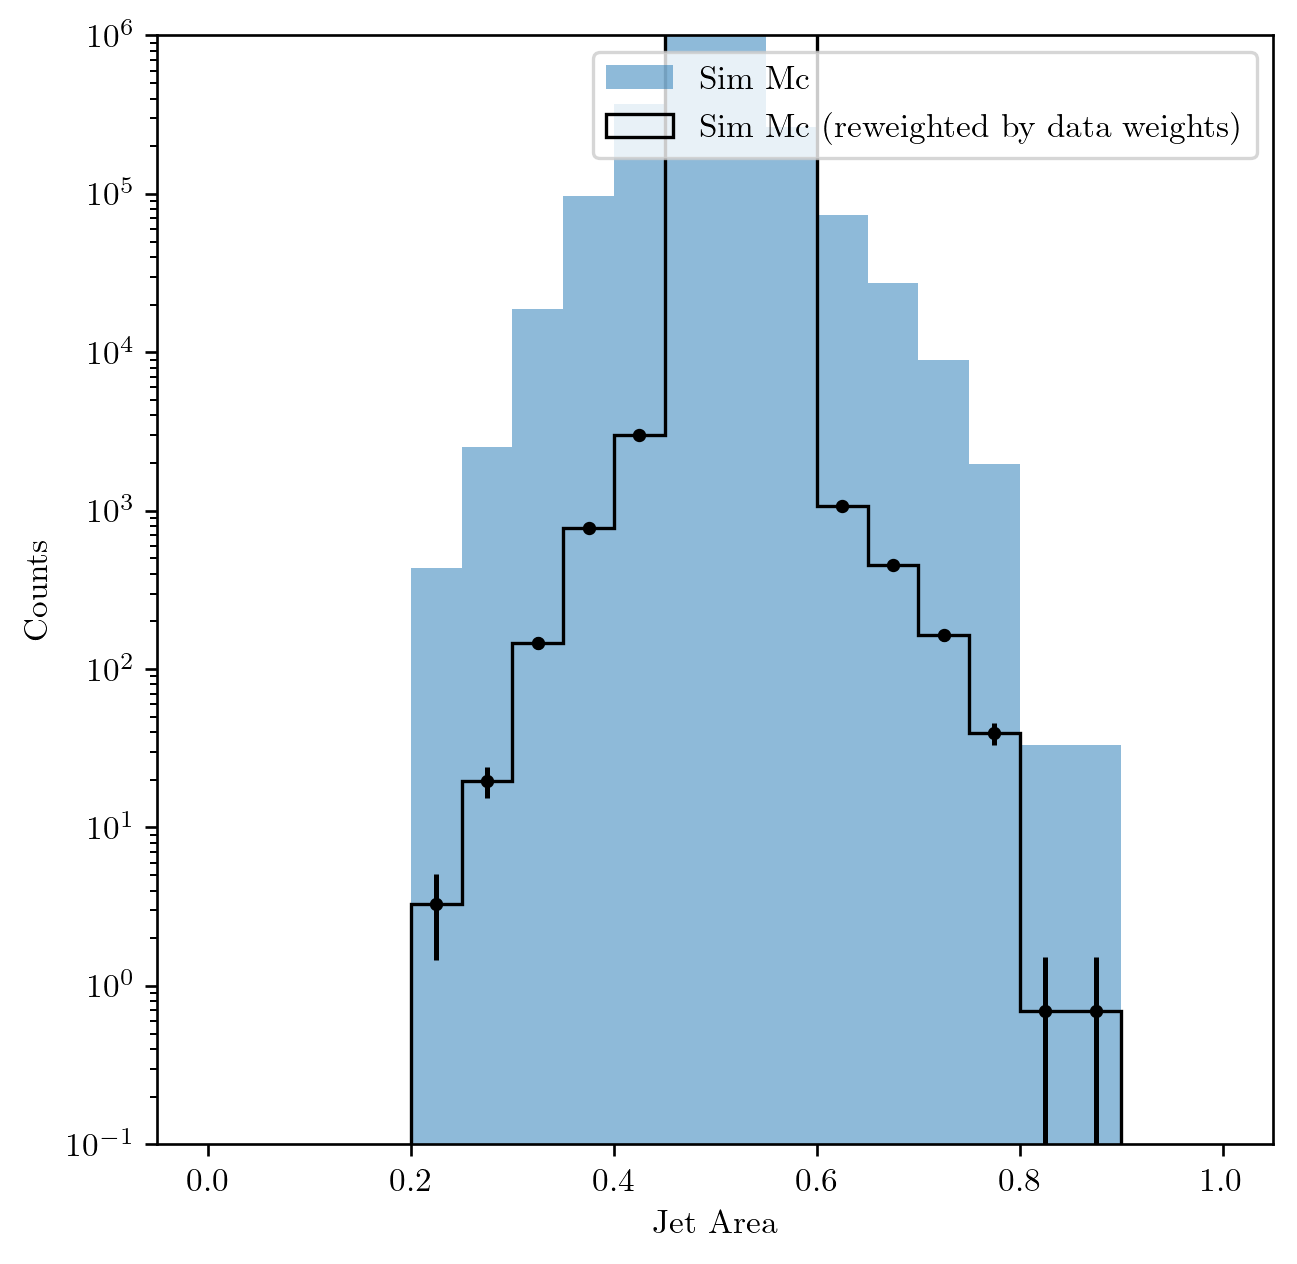

In [21]:
wdata = weights[selectedIteration,0,:] #weights after last iteration for pull after step 1

# for i,(obkey,ob) in enumerate(obs.items()):
# terate only in those observables which are in features:
for obkey,ob in obs.items():
    if obkey not in features:
        continue

    plt .rcParams['figure.figsize'] = (6,6)
    plt .rcParams['figure.dpi'] = 240

    fig, ax = plt.subplots()

    ax.hist(trainGen[obkey], bins=ob['bins_mc'], **plot_style_2, label='Sim Mc', weights=  100*trainWts)
    entries, edges, _ = ax.hist(trainGen[obkey], bins=ob['bins_mc'], histtype="step", label='Sim Mc (reweighted by data weights)',color="black",weights=100*wdata)

    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    # draw errobars, use the sqrt error. You can use what you want there
    # poissonian 1 sigma intervals would make more sense
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='k.')
    # legend = ax.legend(loc='upper left',    frameon=False)
    # plt.setp(legend.get_title(), multialignment='center')
    plt.yscale('log')
    plt.ylim(1e-1, 10e5)
    plt.xlabel(ob['xlabel'])
    plt.ylabel(ob['ylabel'])
    plt.legend()
    fig.show()

    fig.savefig(f"{saveFolder}/reweight2_{obkey}.pdf", bbox_inches='tight')

/home/prozorov/dev/star/unfold/Tanmay/modplot.py:142: RuntimeWarning: invalid value encountered in divide
  hist /= density_int
/home/prozorov/dev/star/unfold/Tanmay/modplot.py:143: RuntimeWarning: invalid value encountered in divide
  errs /= density_int


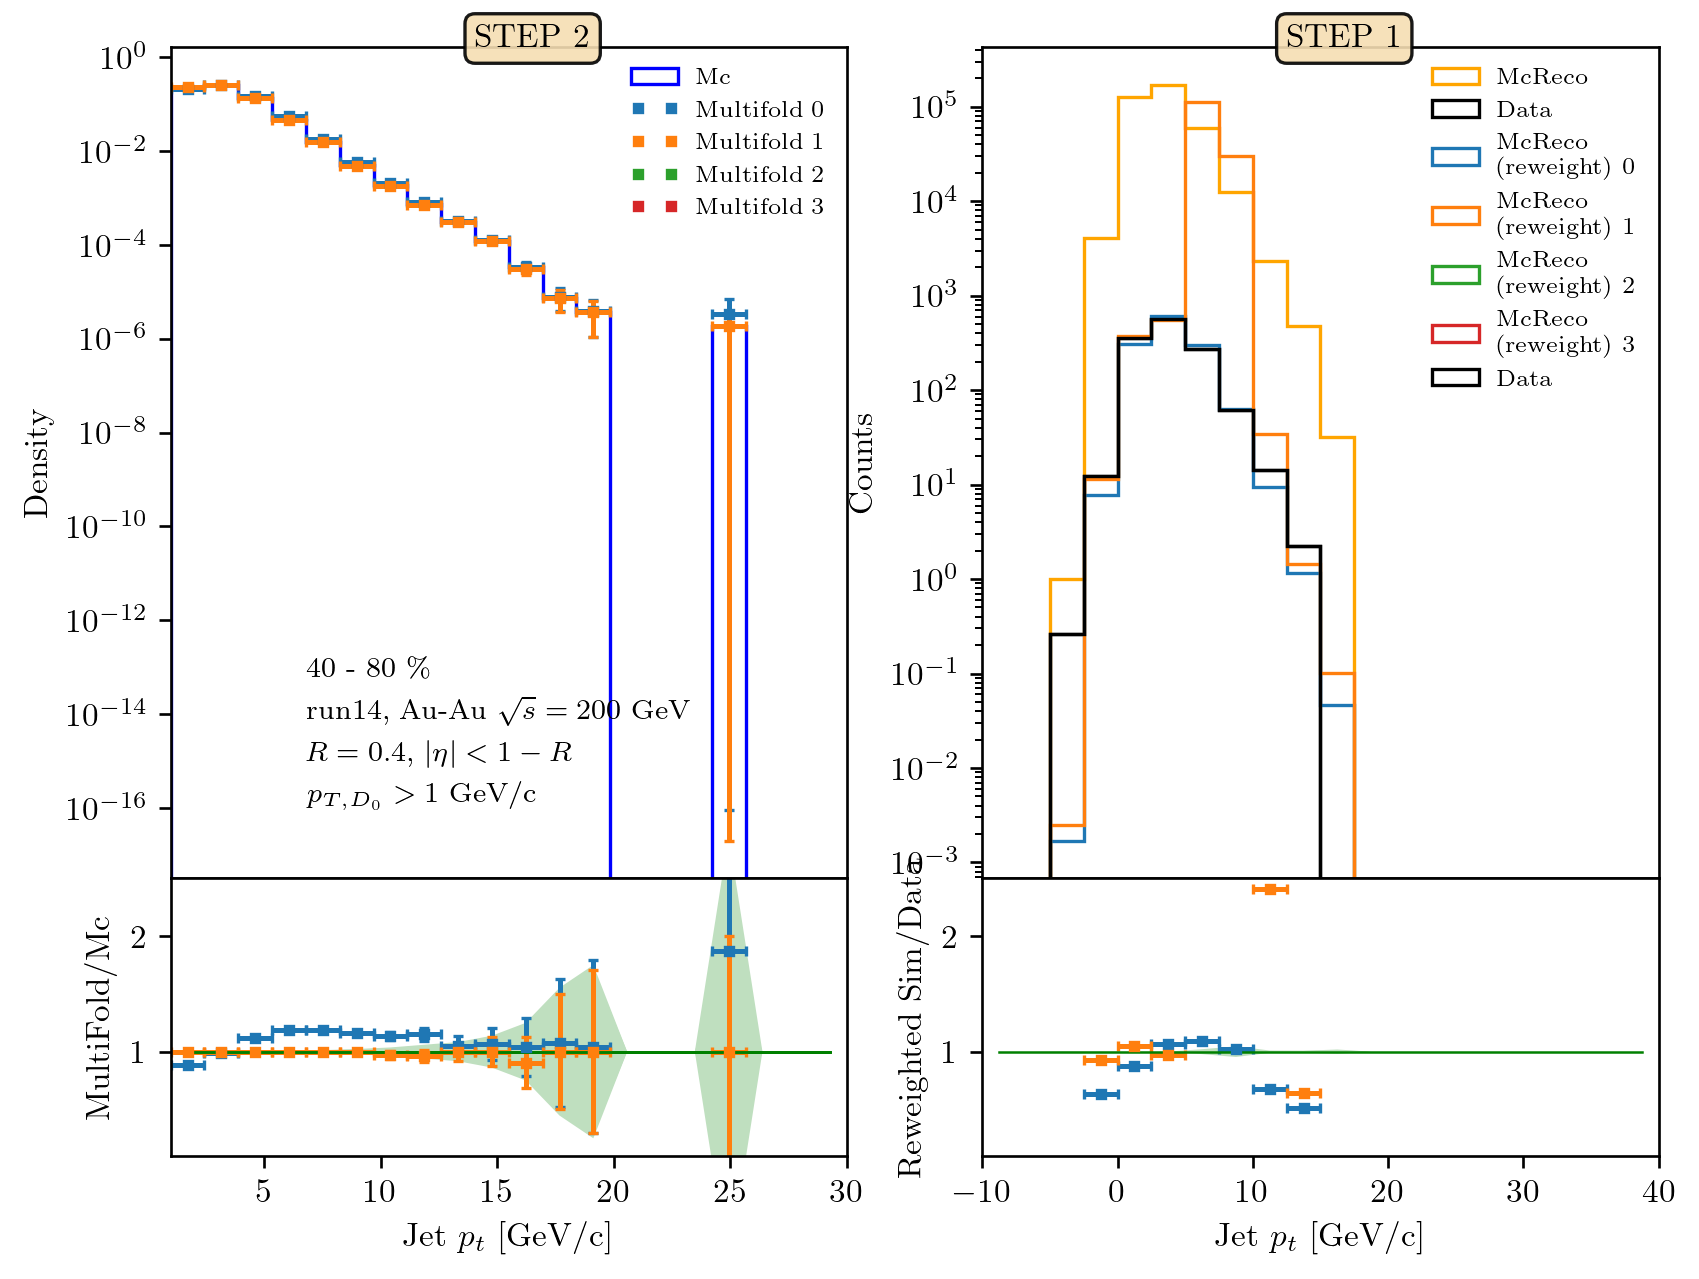

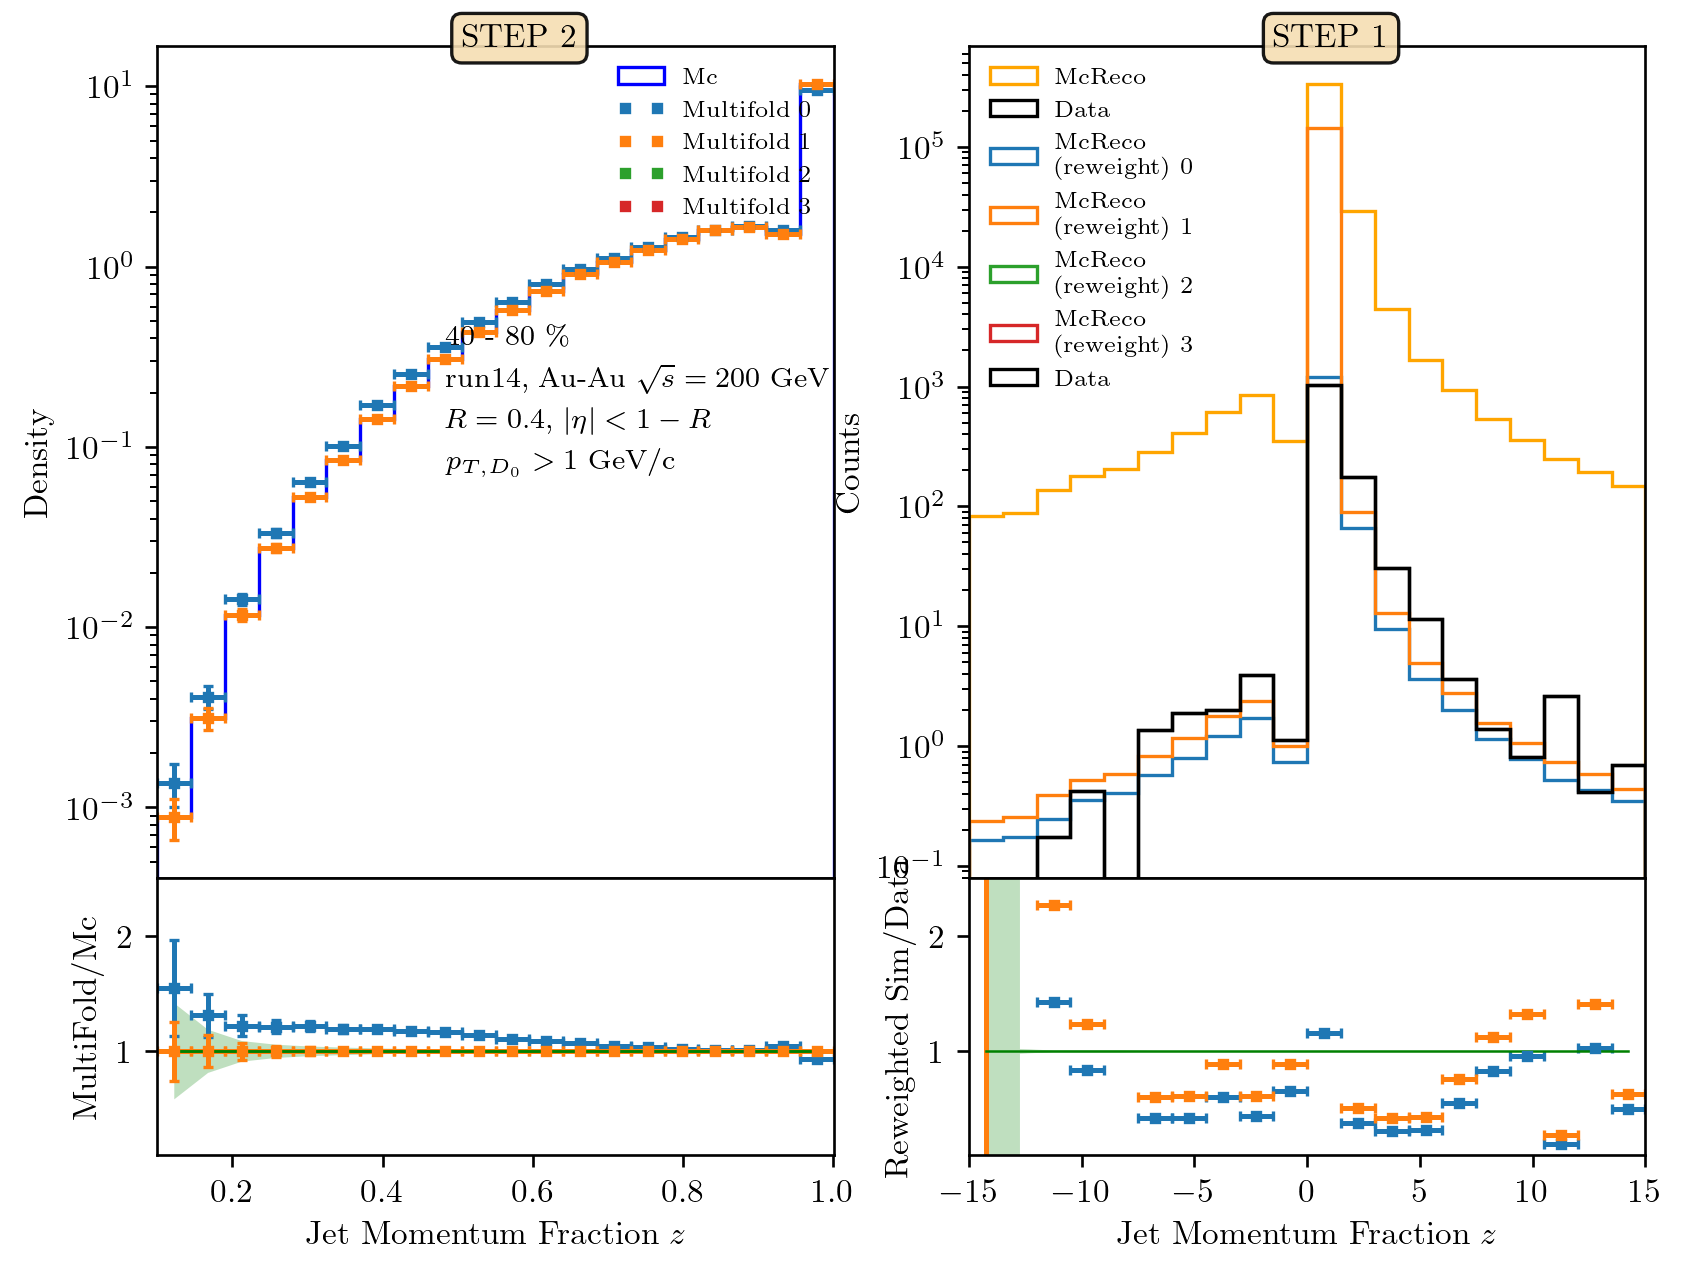

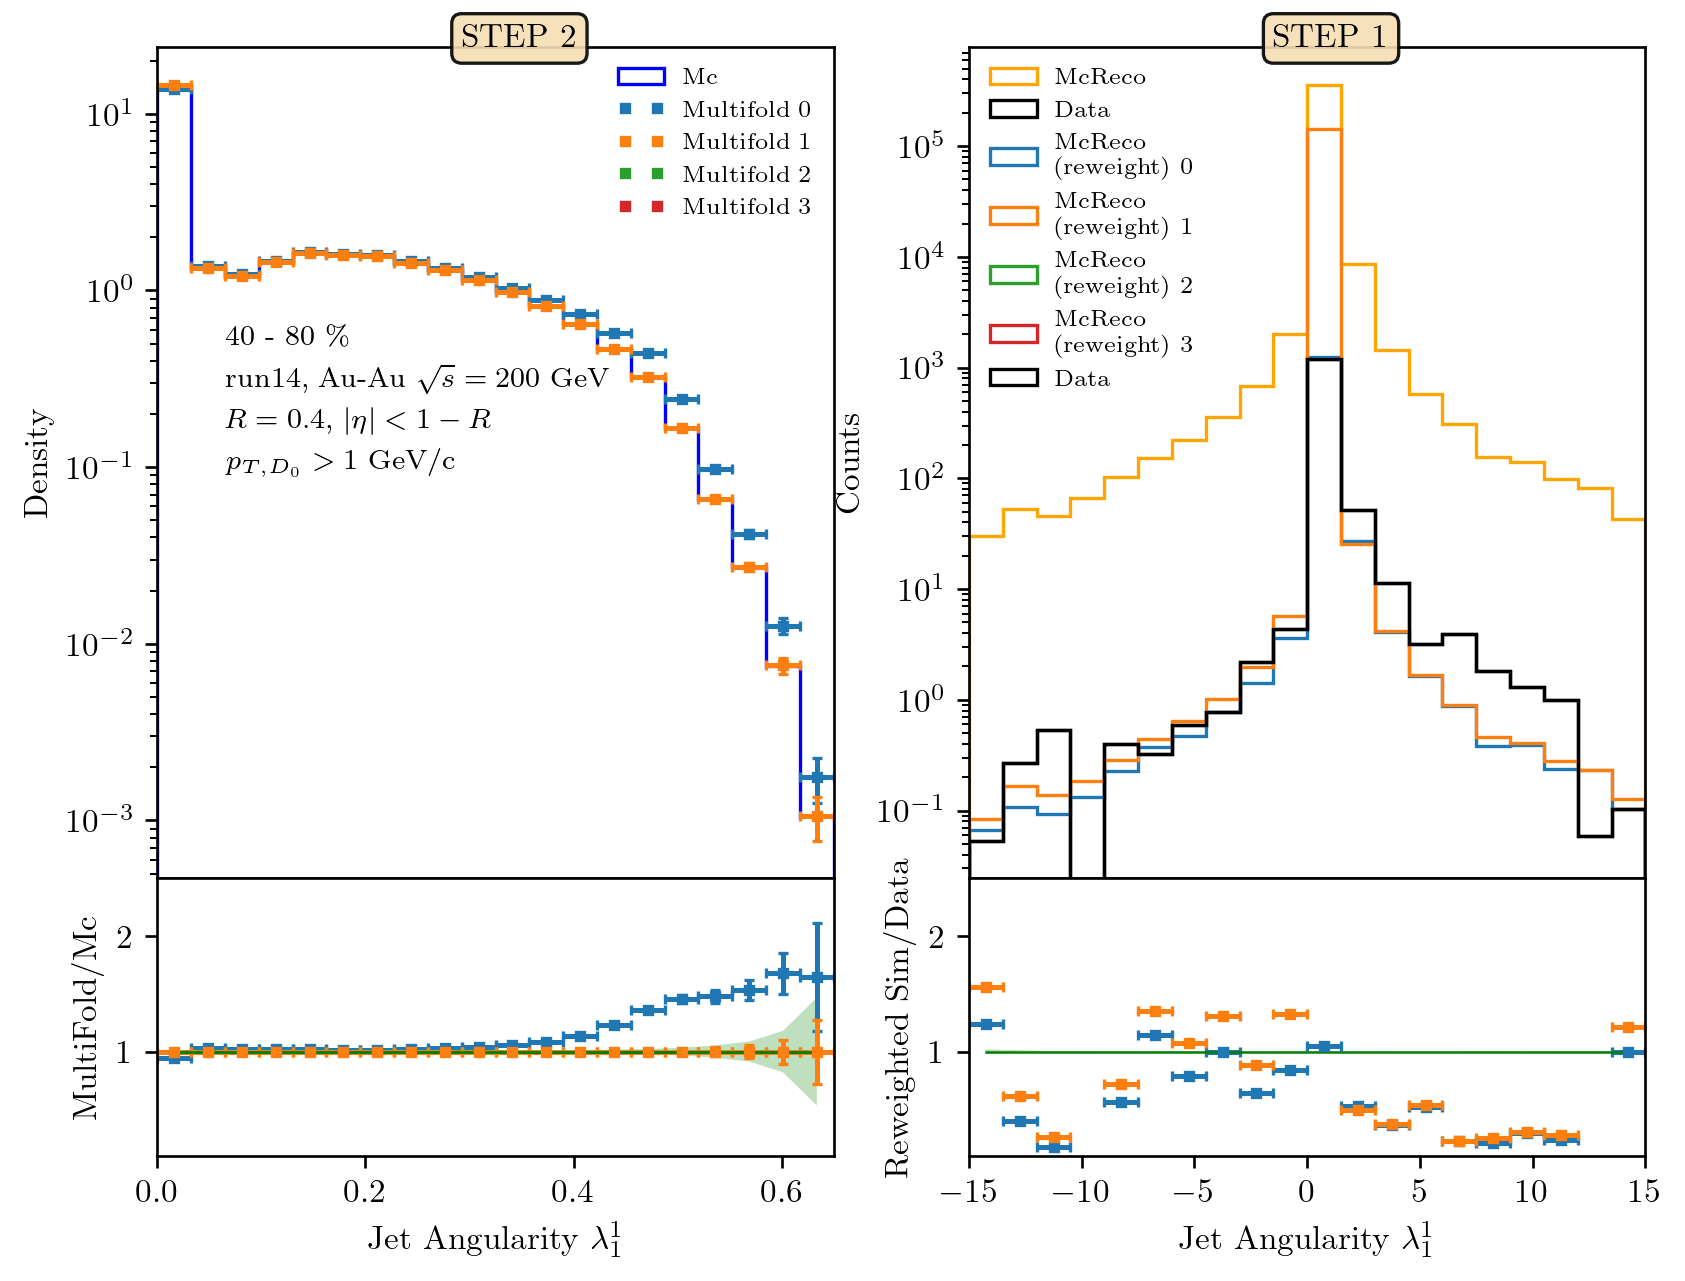

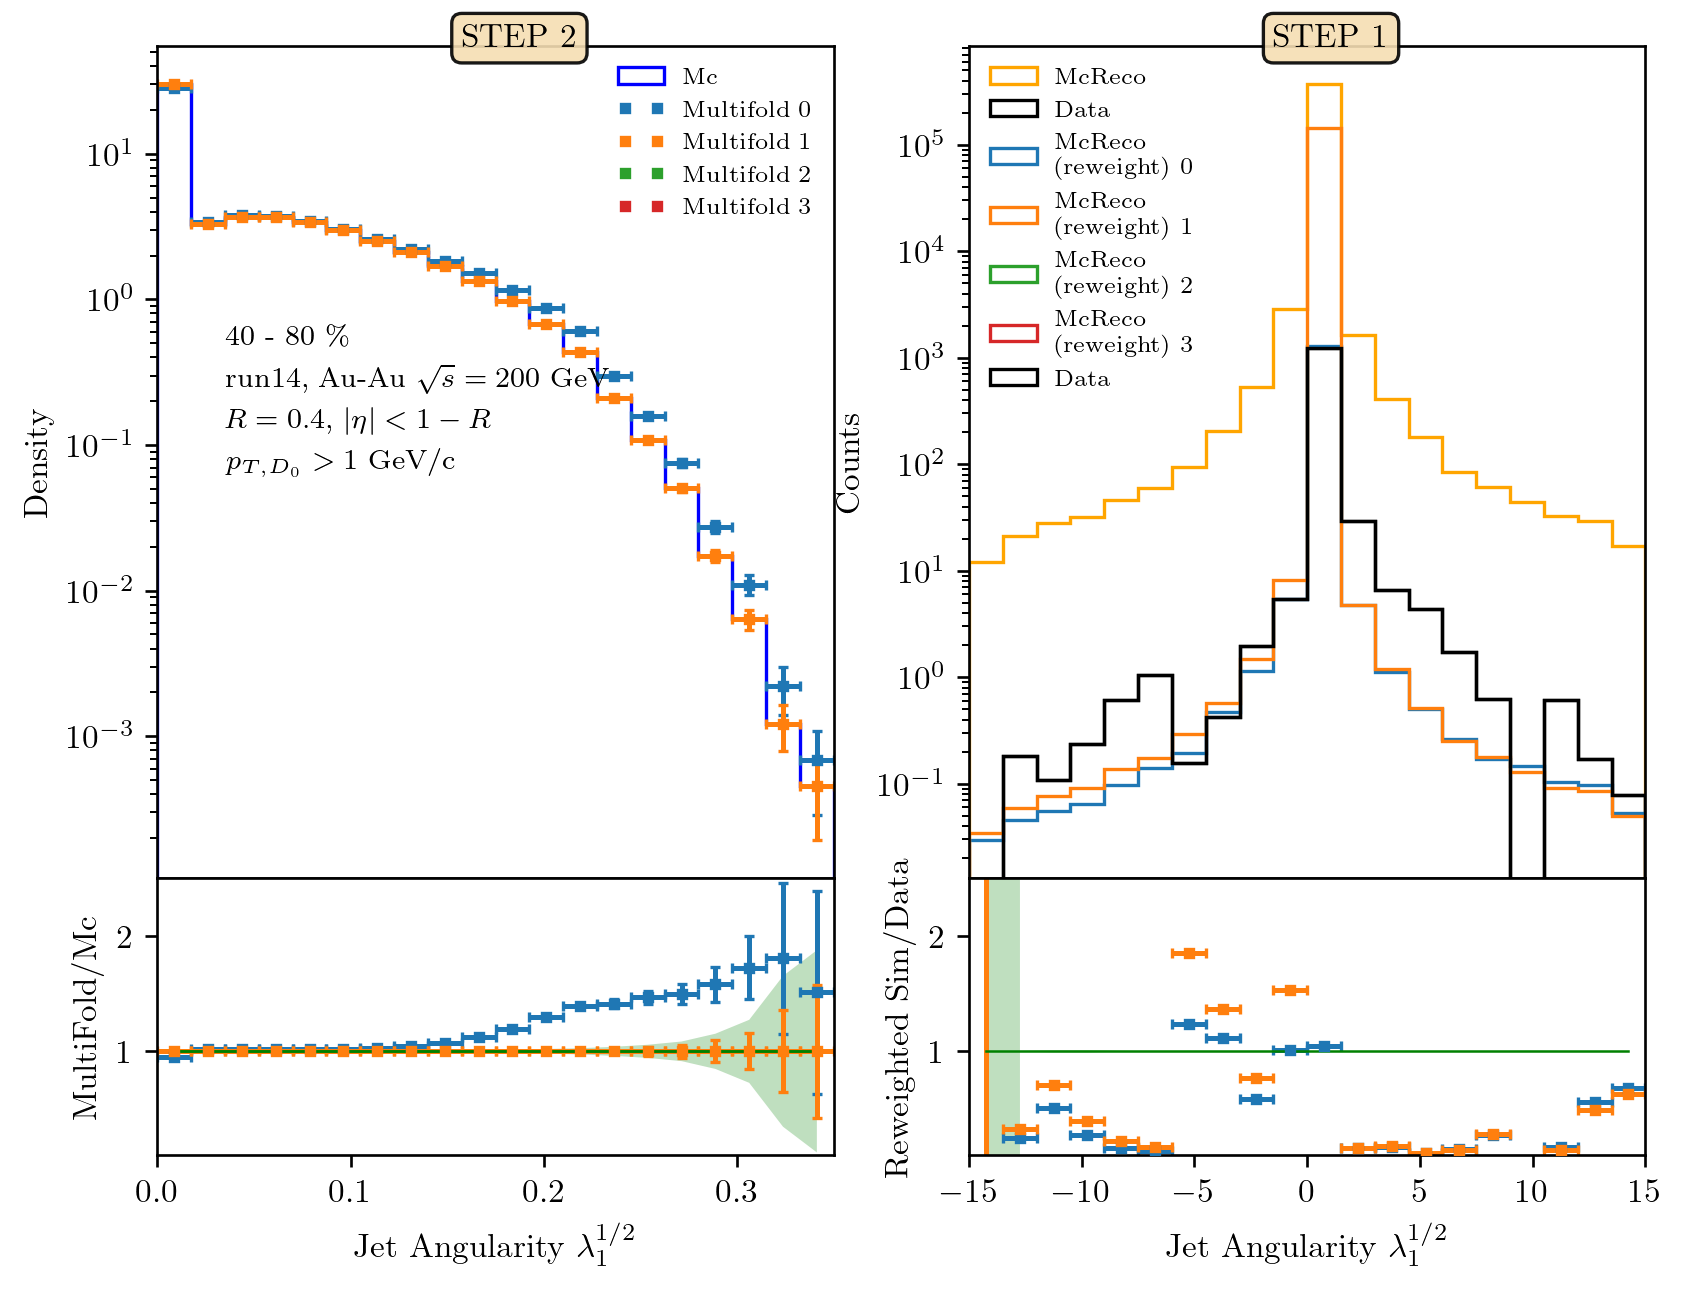

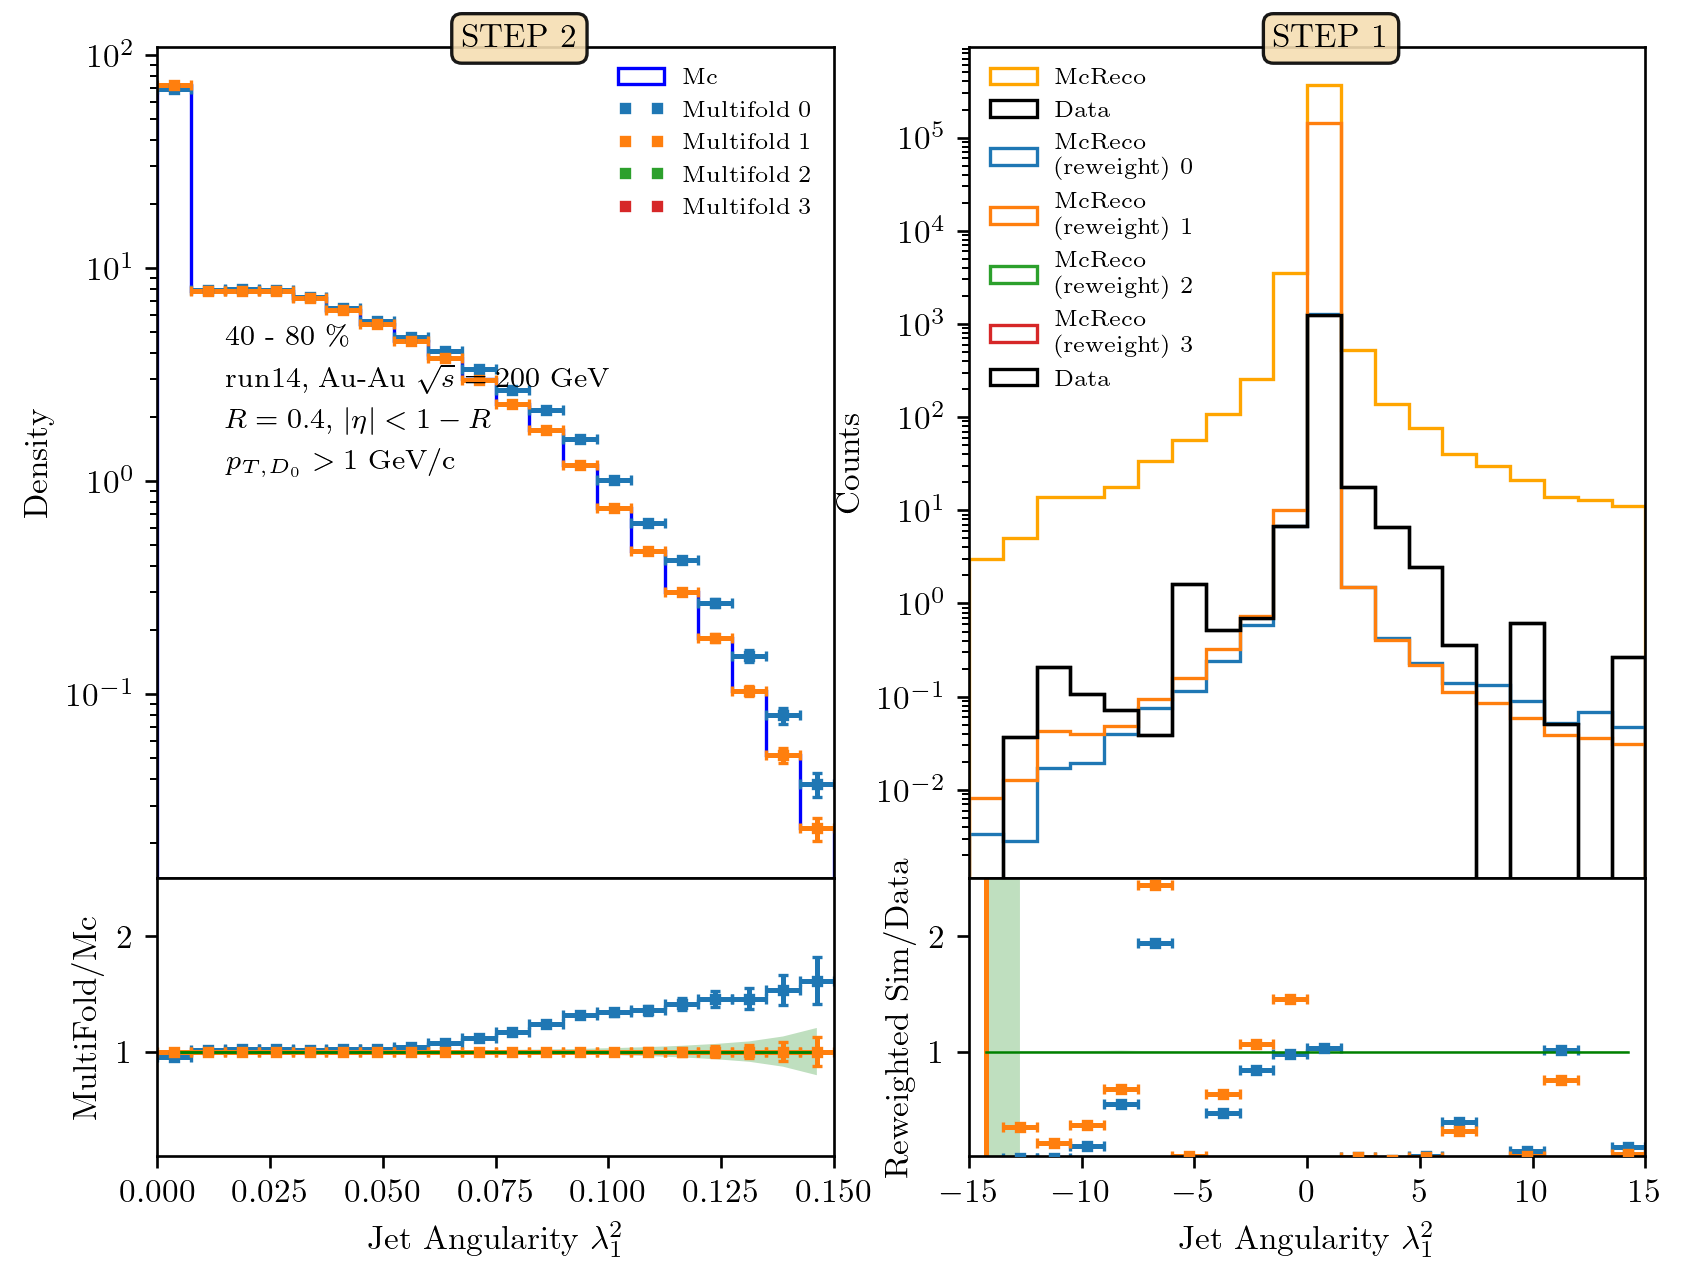

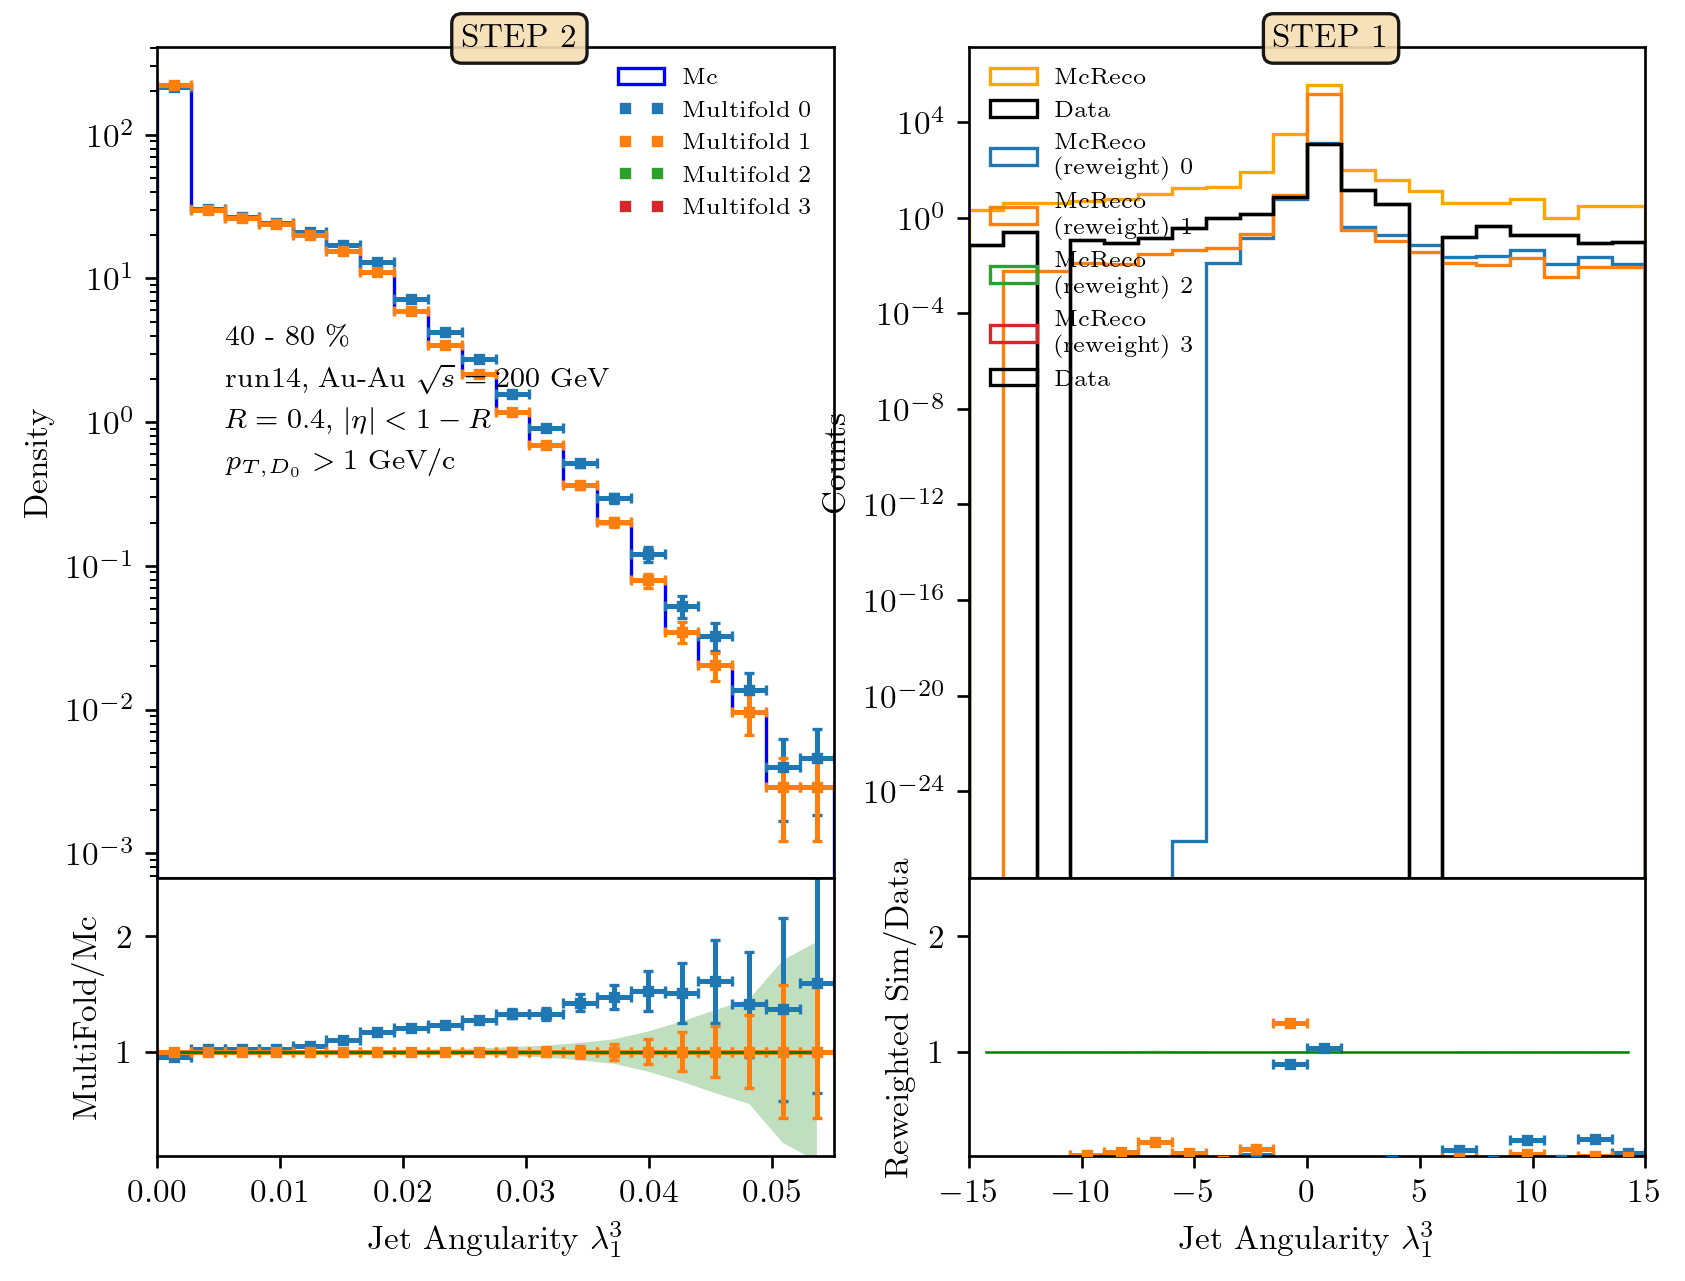

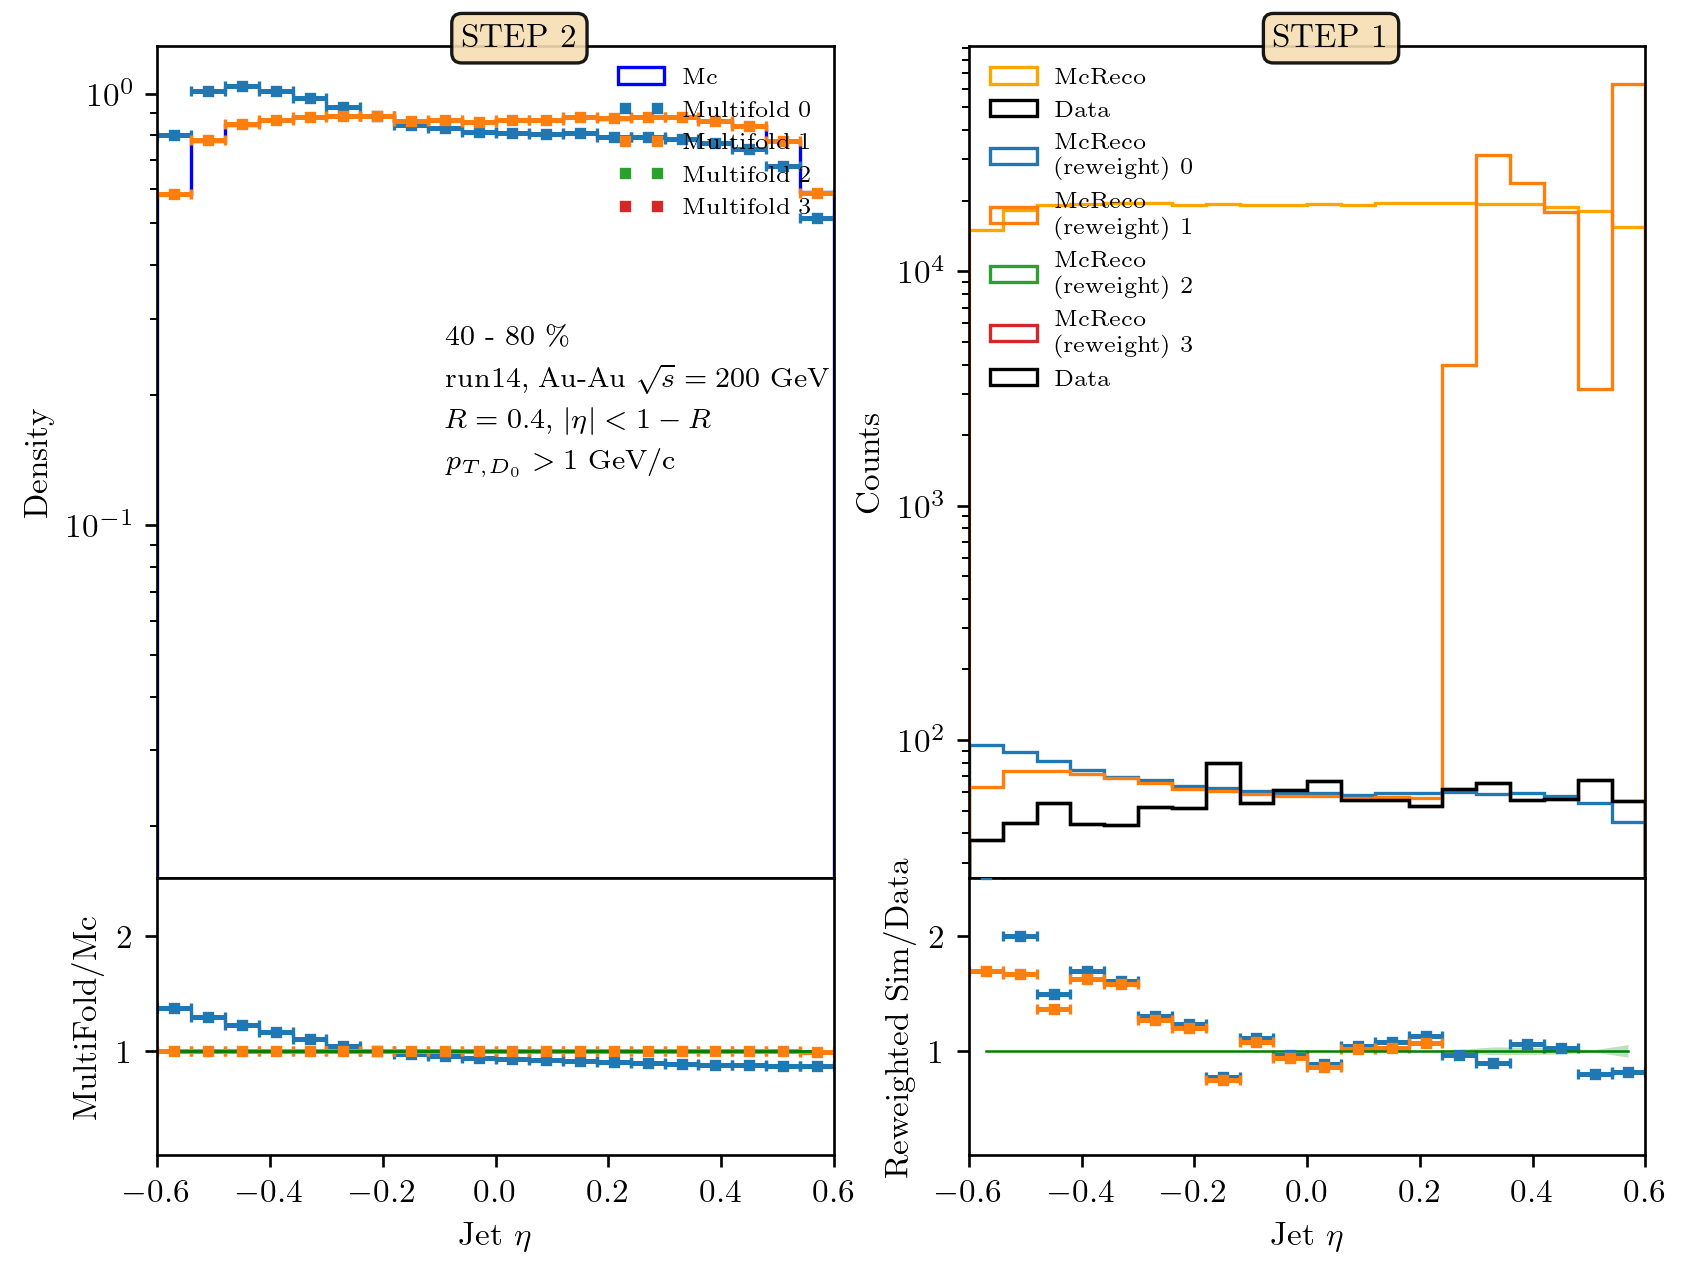

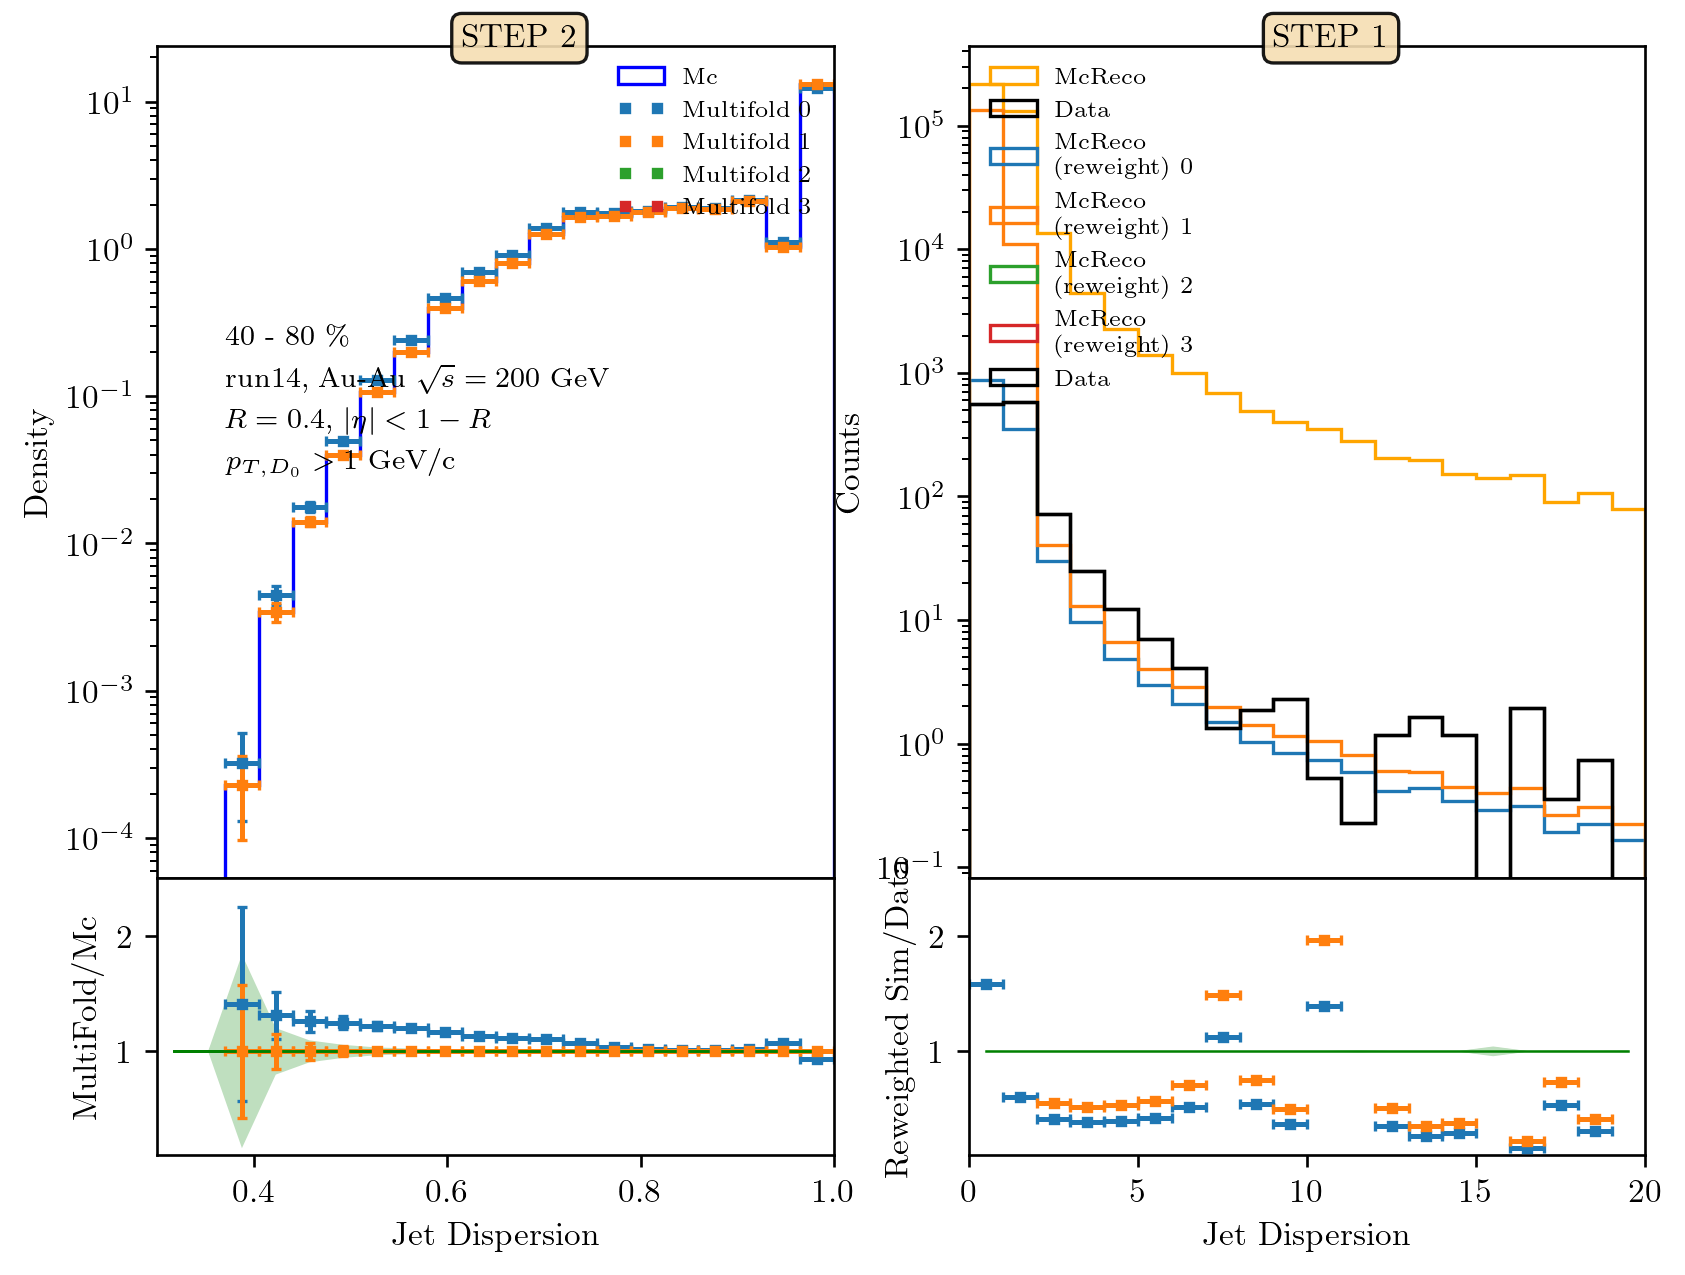

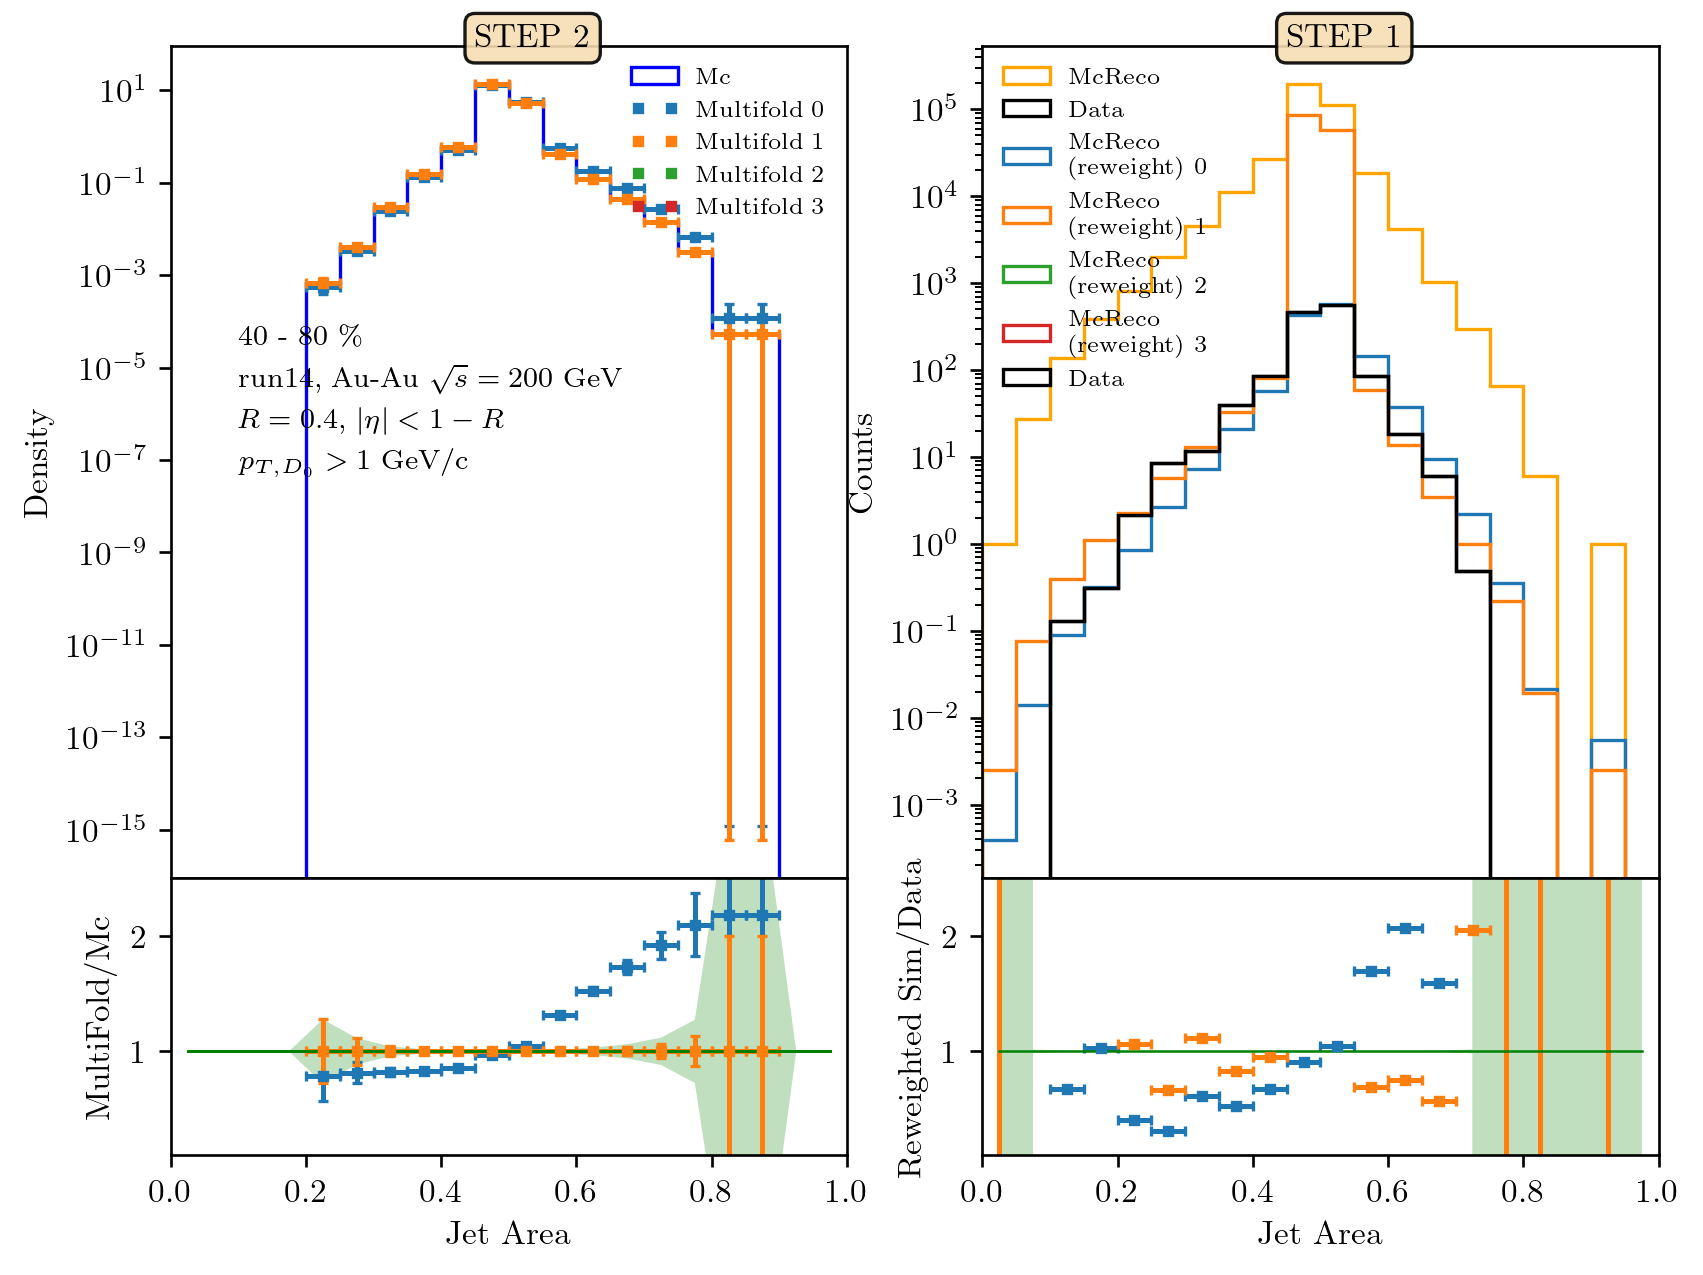

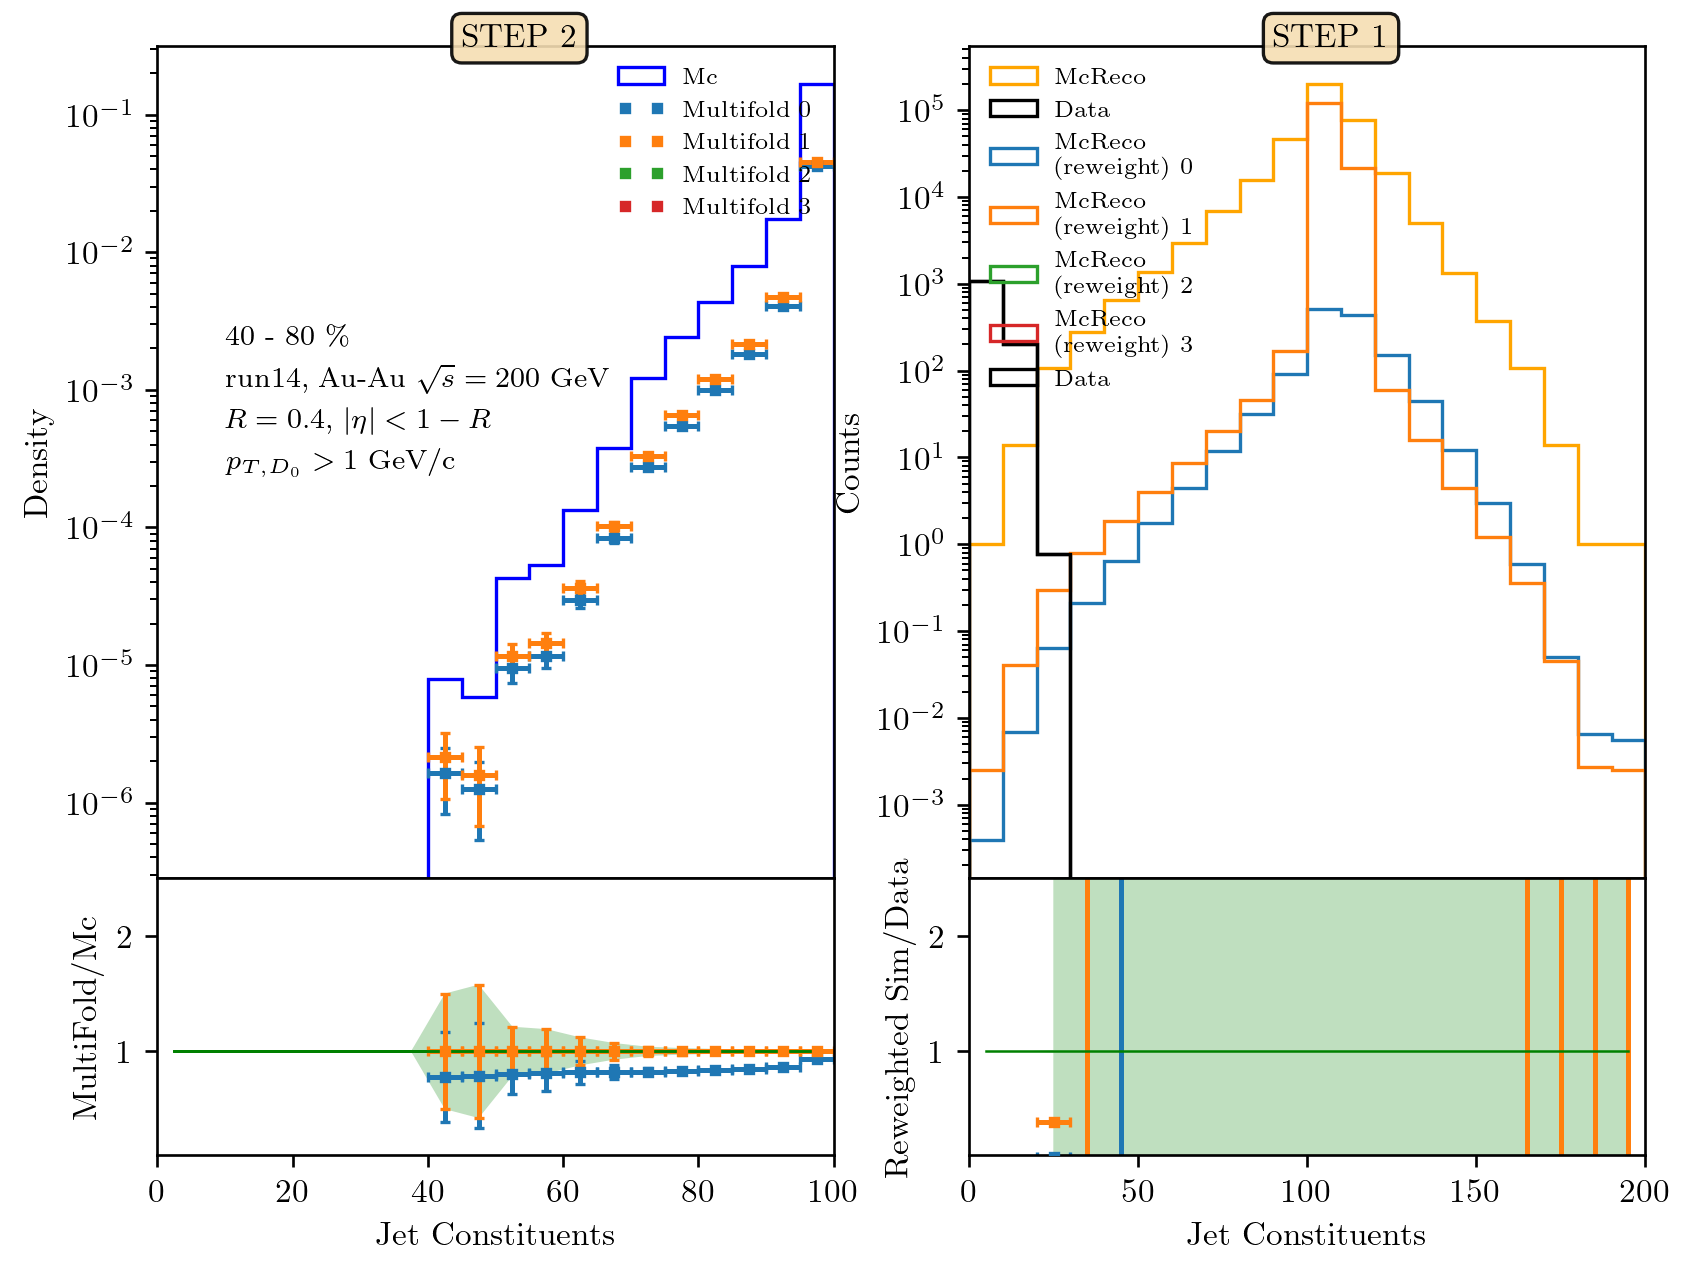

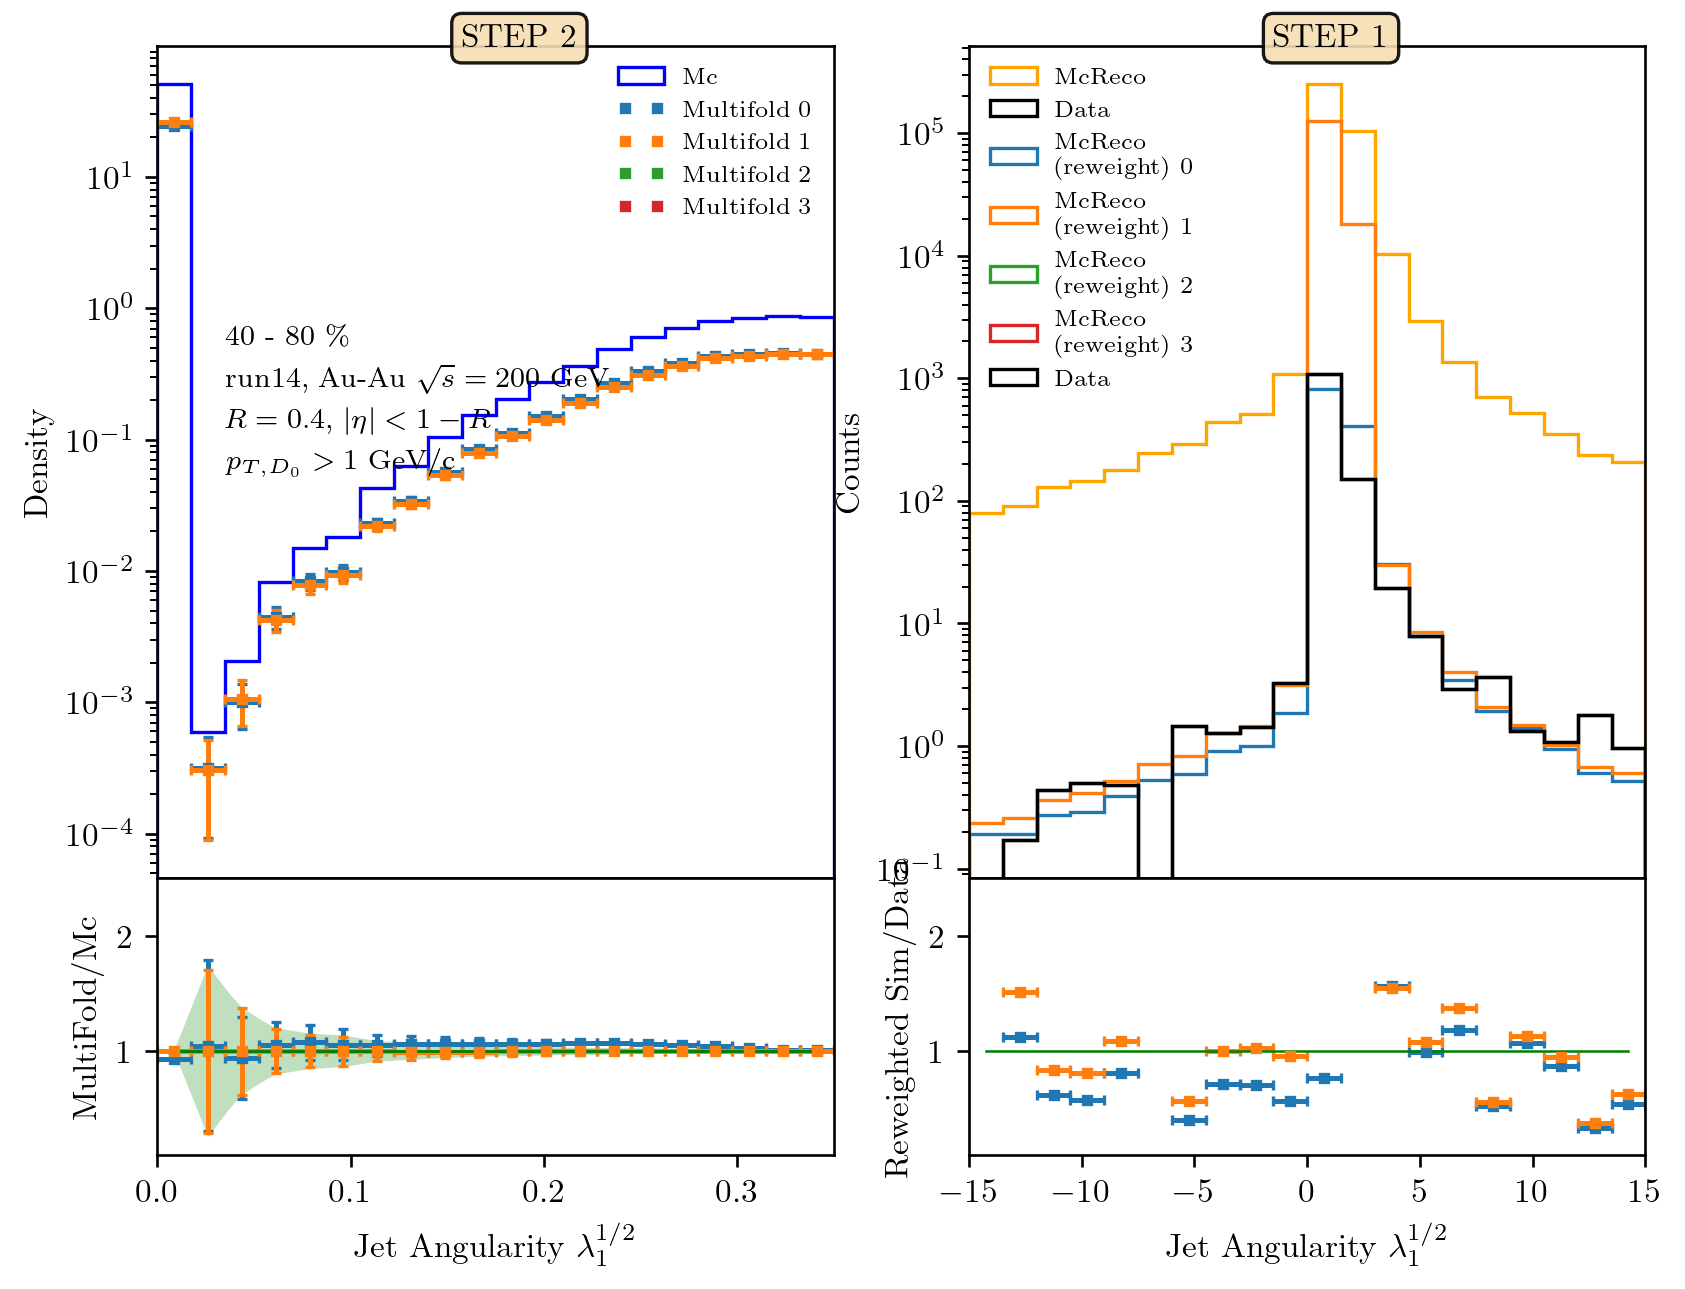

In [22]:
iteration_nice_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i,(obkey,ob) in enumerate(obs.items()):
    fig = plt.figure(figsize=(8,6))
    gs = fig.add_gridspec(2, 2, hspace=0,height_ratios=[3, 1] )
    axs= gs.subplots()
    mcAxis = axs[0,0]
    recoAxis = axs[0,1]
    ratioMcAxis = axs[1,0]
    ratioRecoAxis = axs[1,1]
    # set invisible x axis of mcAxis and recoAxis
    mcAxis.xaxis.set_visible(False)
    recoAxis.xaxis.set_visible(False)
    mcAxis.set_yscale('log')
    recoAxis.set_yscale('log')
    # set x and y limits
    mcAxis.set_xlim(ob['xlim'])
    recoAxis.set_xlim(ob['xlim_det'])
    ratioMcAxis.set_xlim(ob['xlim'])
    ratioRecoAxis.set_xlim(ob['xlim_det'])
    # mcAxis.set_ylim(ob['ylim'])
    

    if isClosureTest:
        ratioMcAxis.set_ylim(0.75, 1.25)
        ratioRecoAxis.set_ylim(0.75, 1.25)
    else:
        ratioMcAxis.set_ylim(0.1, 2.5)
        ratioRecoAxis.set_ylim(0.1, 2.5)


    # set titles for axis
    ratioMcAxis.set_xlabel(ob['xlabel'])
    ratioMcAxis.set_ylabel('MultiFold/Mc')
    mcAxis.set_ylabel('Counts')
    ratioRecoAxis.set_xlabel(ob['xlabel'])
    ratioRecoAxis.set_ylabel('Reweighted Sim/Data')
    recoAxis.set_ylabel(ob['ylabel'])

    # Plot the Unfolded Distributions of the Observable
    settingDensity = False
    # if not isClosureTest:
    settingDensity = True
    mcAxis.set_ylabel('Density')  

    mcAxis.hist(trainGen[obkey], bins=ob['bins_mc'], color='blue', label='Mc', **hist_style, density=settingDensity)
    mcHist, mcHist_unc = modplot.calc_hist(trainGen[obkey], bins=ob['bins_mc'], density=settingDensity)[:2]

    for i in range(iterations):
        unfolded, unfolded_unc = modplot.calc_hist(trainGen[obkey], weights=weights[ i,1,:], bins=ob['bins_mc'], density=settingDensity)[:2]
        mcAxis.plot(ob['midbins_mc'], unfolded, **omnifold_style, label= f'Multifold {i}', color=iteration_nice_colors[i])
        mcAxis.errorbar(ob['midbins_mc'], unfolded, xerr=ob['binwidth_mc']/2, yerr=unfolded_unc, 
                                            color=iteration_nice_colors[i], **modplot.style('errorbar'))
    
        # Plot the Ratios of the OmniFold distribution to truth (with statistical uncertainties)
        mc_ratio = unfolded/(mcHist+ 10**-50)
        ratioMcAxis.plot(ob['midbins_mc'], mc_ratio,**omnifold_style)
        ratioMcAxis.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)

        # ratio uncertainties
        mc_ratio_unc = unfolded_unc/(mcHist + 10**-50)
        ratioMcAxis.fill_between(ob['midbins_mc'], 1 - mc_ratio_unc, 1 + mc_ratio_unc,
                        facecolor=truth_style['facecolor'], zorder=-2)
        ratioMcAxis.errorbar(ob['midbins_mc'], mc_ratio, xerr=ob['binwidth_mc']/2, yerr=mc_ratio_unc,
                                                color=iteration_nice_colors[i], **modplot.style('errorbar'))
    

 # ///////////////////////////////////////////////////
    

   # plot the "sim" histogram of the observable
    recoAxis.hist(trainReco[obkey], bins=ob['bins_det'], color='orange', label='McReco', **hist_style)
    recoHist, edges, _ = recoAxis.hist(testReco[obkey], bins=ob['bins_det'], color='black', label='Data', weights =testWts, **hist_style)

    # plot the "sim" histogram of the observable
    for i in range(iterations):
        reweightedSim, edges, _ = recoAxis.hist(trainReco[obkey], bins=ob['bins_det'], color= iteration_nice_colors[i], weights=weights[i, 0,:], label='McReco\n(reweight) {}'.format(i), **hist_style)
        bin_centers = 0.5 * (edges[:-1] + edges[1:])
    # recoAxis.errorbar(bin_centers, reweightedSim, yerr=np.sqrt(entries), color='brown', fmt='',linestyle='')

   # Plot the Ratios of the Scaled Sim to Data (with statistical uncertainties)
        reco_ratio = reweightedSim/(recoHist+ 10**-50)
        ratioRecoAxis.plot(bin_centers, reco_ratio, **omnifold_style, color=iteration_nice_colors[i])

    # ratio uncertainties
        reco_ratio_unc = np.sqrt(reweightedSim)/(ob['data_hist'] + 10**-50)
        ratioRecoAxis.fill_between(bin_centers, 1 - reco_ratio_unc, 1 + reco_ratio_unc,
                        facecolor=truth_style['facecolor'], zorder=-2)
        ratioRecoAxis.errorbar(bin_centers, reco_ratio, xerr=ob['binwidth_det']/2, yerr=reco_ratio_unc, 
                                            color=iteration_nice_colors[i], **modplot.style('errorbar'))
 
    ratioRecoAxis.plot([np.min(bin_centers), np.max(bin_centers)], [1, 1], '-', color='green', lw=0.75)
        # plot the "data" histogram of the observable
    recoHist, edges, _ = recoAxis.hist(testReco[obkey], bins=ob['bins_det'], color='black', label='Data', weights =testWts, **hist_style)

    # legend style and ordering
    loc = ob.get('legend_loc', 'upper right')
    modplot.legend( ax=mcAxis, frameon=False,  loc=loc, fontsize = 7)
    loc = ob.get('legend_loc', 'upper left')
    modplot.legend( ax=recoAxis, frameon=False,  loc=loc, fontsize = 7)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.05, ax=mcAxis,
    # centrality label
                 line_0=r'{} - {} \%'.format(centralityBins[0], centralityBins[1]), 
                 line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV',
                 line_2=r'$R=0.4$, $|\eta|<1-R$',
                 line_3=r'$p_{T,D_0}>1$ GeV/c')


    # place a text box in upper left in axes coords

    if isClosureTest:
        mcAxis.text(0.65, 0.7, 'Closure Test',  transform=mcAxis.transAxes, bbox=dict(boxstyle='round', facecolor='turquoise', alpha=0.5, pad= 1))
    mcAxis.text(0.45, 1., 'STEP 2',  transform=mcAxis.transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    recoAxis.text(0.45, 1., 'STEP 1',  transform=recoAxis.transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    # recoAxis.text(0.28, 0.1, 'HI Background subtracted',  transform=recoAxis.transAxes, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.2))

        # # save plot (by default in the same directory as this notebook).
    fig.savefig(f"{saveFolder}/omnifold_{obkey}.pdf", bbox_inches='tight')
    plt.show()
